In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2.5)
import warnings
warnings.filterwarnings('ignore')

# for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# For Checking models
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split

In [2]:
# Load data
df = pd.read_csv('bank.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [471]:
from sklearn.preprocessing import LabelEncoder
le_y = LabelEncoder()
df['y'] = le_y.fit_transform(df['y'])
print(le_y.classes_)    # le_y의 classes_
print(le_y.inverse_transform([0,1]))
df.head()

['no' 'yes']
['no' 'yes']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


- 아래와 같이 결측값은 존재하지 않는다.

In [472]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

## 0. 사전 데이터 준비
 주어진 데이터는 하나의 데이터셋이므로 이 중 약 10%(4118개)를 test set으로 미리 분할한다. EDA 등을 진행할 때, test set은 unseen data이므로 train set에 대해서만 진행한다.

In [473]:
X = df.drop('y', axis=1)
y = df['y']

In [474]:
pd.Series(y).value_counts()

0    36548
1     4640
Name: y, dtype: int64

Text(0, 0.5, '')

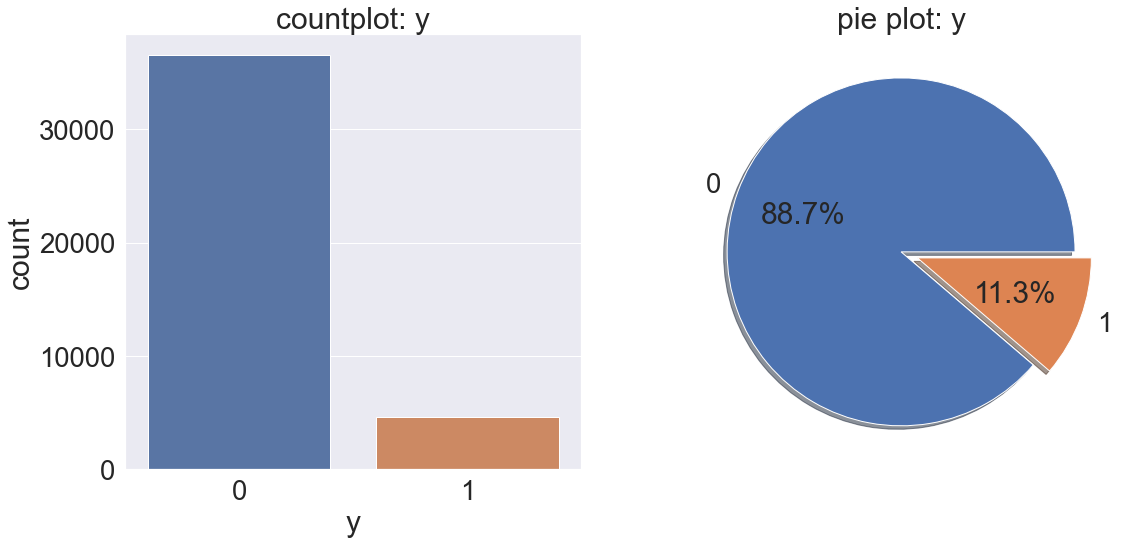

In [475]:
f, ax =plt.subplots(1,2,figsize=(18,8))

sns.countplot(y,ax=ax[0])
ax[0].set_title('countplot: y')

pd.Series(y).value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%', shadow=True, ax=ax[1])
ax[1].set_title('pie plot: y')
ax[1].set_ylabel('')

- 위와 같이 y에 대해 불균형한 데이터이므로 train set과 test set으로 나눌 때 `stratify=y` 옵션을 주어서 층화추출을 한다. 
1. 추후 train set에서 SMOTE 등의 방법을 이용해 **불균형 데이터 문제를 해소할 필요성**이 보인다.
2. 모델의 성능을 측정할 때, accuracy가 아닌 True Positive 또는 **Recall 또는 Precision을 사용**한다.

In [476]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12, test_size=0.1)

# train set & test set 생성
df_train = X_train
df_train['y'] = y_train
df_train.reset_index(drop=True)

df_test = X_test
df_test['y'] = y_test
df_test = X_test.reset_index(drop=True)

- 그러므로 최종적으로 준비한 데이터는 다음과 같다.

In [477]:
print('df_train shape: {}'.format(df_train.shape))
print('df_test shape: {}'.format(df_test.shape))
print('y_train values: \n{}'.format(df_train['y'].value_counts()))
print('y_test values: \n{}'.format(pd.Series(y_test).value_counts()))

df_train shape: (37069, 21)
df_test shape: (4119, 21)
y_train values: 
0    32893
1     4176
Name: y, dtype: int64
y_test values: 
0    3655
1     464
Name: y, dtype: int64


In [478]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37069 entries, 26367 to 18945
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             37069 non-null  int64  
 1   job             37069 non-null  object 
 2   marital         37069 non-null  object 
 3   education       37069 non-null  object 
 4   default         37069 non-null  object 
 5   housing         37069 non-null  object 
 6   loan            37069 non-null  object 
 7   contact         37069 non-null  object 
 8   month           37069 non-null  object 
 9   day_of_week     37069 non-null  object 
 10  duration        37069 non-null  int64  
 11  campaign        37069 non-null  int64  
 12  pdays           37069 non-null  int64  
 13  previous        37069 non-null  int64  
 14  poutcome        37069 non-null  object 
 15  emp.var.rate    37069 non-null  float64
 16  cons.price.idx  37069 non-null  float64
 17  cons.conf.idx   37069 non-n

In [335]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [336]:
# sns.pairplot(df_train)

## 1. EDA for Bank client data

### (1) age

In [337]:
df_train['age'].describe()

count    37069.000000
mean        40.016267
std         10.401295
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: age, dtype: float64

In [338]:
print('최고령 고객: {:>10} Years'.format(df_train.age.max()))
print('최연소 고객: {:>10} Years'.format(df_train.age.min()))
print('평균 고객 나이: {:>10.2f} Years'.format(df_train.age.mean()))

최고령 고객:         98 Years
최연소 고객:         17 Years
평균 고객 나이:      40.02 Years


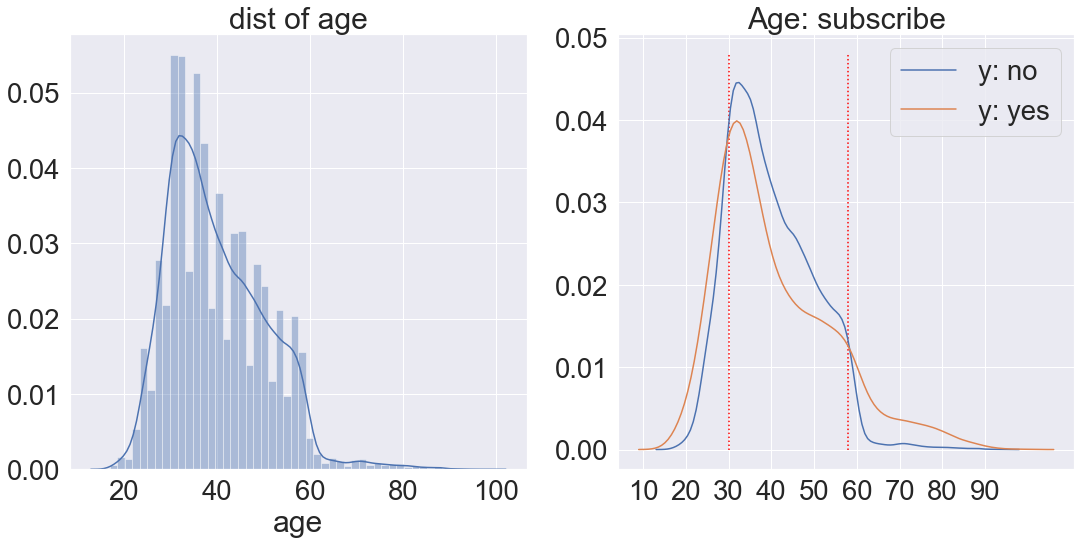

In [339]:
fig, ax = plt.subplots(1,2,figsize=(18,8))

sns.distplot(df_train['age'], ax=ax[0])
ax[0].set_title('dist of age')

sns.kdeplot(df_train.loc[df_train['y']==0,'age'], ax=ax[1])
sns.kdeplot(df_train.loc[df_train['y']==1,'age'], ax=ax[1])
ax[1].set_xticks(range(0,100,10))
ax[1].legend(['y: no', 'y: yes'])
ax[1].set_title('Age: subscribe')
ax[1].vlines(ymin=0, ymax=0.048, x= [30,58], color='red',linestyles='dotted')

plt.show()

- 30살 미만과 60살 이상에서 정기 예금에 가입한 사람이 더 많다.
- 정기 예금 여부에 따른 나이의 분포가 차이가 나기 때문에 age는 y를 예측하는 데 중요한 변수라고 생각된다.
- 또한 이를 카테고리화하는 방안도 생각해볼 수 있다.

In [340]:
temp = df_train.copy()
def cut_age(x):
    if x<=30: return 0
    elif x<=58: return 1
    else: return 2
    
temp['age_cat'] = temp['age'].map(cut_age)

In [341]:
pd.crosstab(temp['age_cat'],temp['y'], margins=True)

y,0,1,All
age_cat,,,
0,5630,1014,6644
1,26261,2690,28951
2,1002,472,1474
All,32893,4176,37069


In [343]:
round(temp[['age_cat','y']].groupby('age_cat').mean(),2)

,y
age_cat,
0,0.15
1,0.09
2,0.32


In [322]:
temp

,previous,y
0,0,0.087700
1,1,0.215205
2,2,0.463343
3,3,0.601010
4,4,0.560606
5,5,0.733333
6,6,0.500000


### (2) job

- y가 0과 1의 값을 갖는 binary형이기 때문에 평균을 내면 가입률이 된다.
- 직업별 정기예금 가입률은 다음과 같다.

In [344]:
df_train[['job','y']].groupby('job').mean().sort_values(by='y',ascending=False).T

job,student,retired,unemployed,admin.,management,technician,self-employed,unknown,housemaid,entrepreneur,services,blue-collar
y,0.317781,0.246906,0.147651,0.128854,0.111822,0.107532,0.106698,0.105442,0.100832,0.085606,0.081376,0.070404


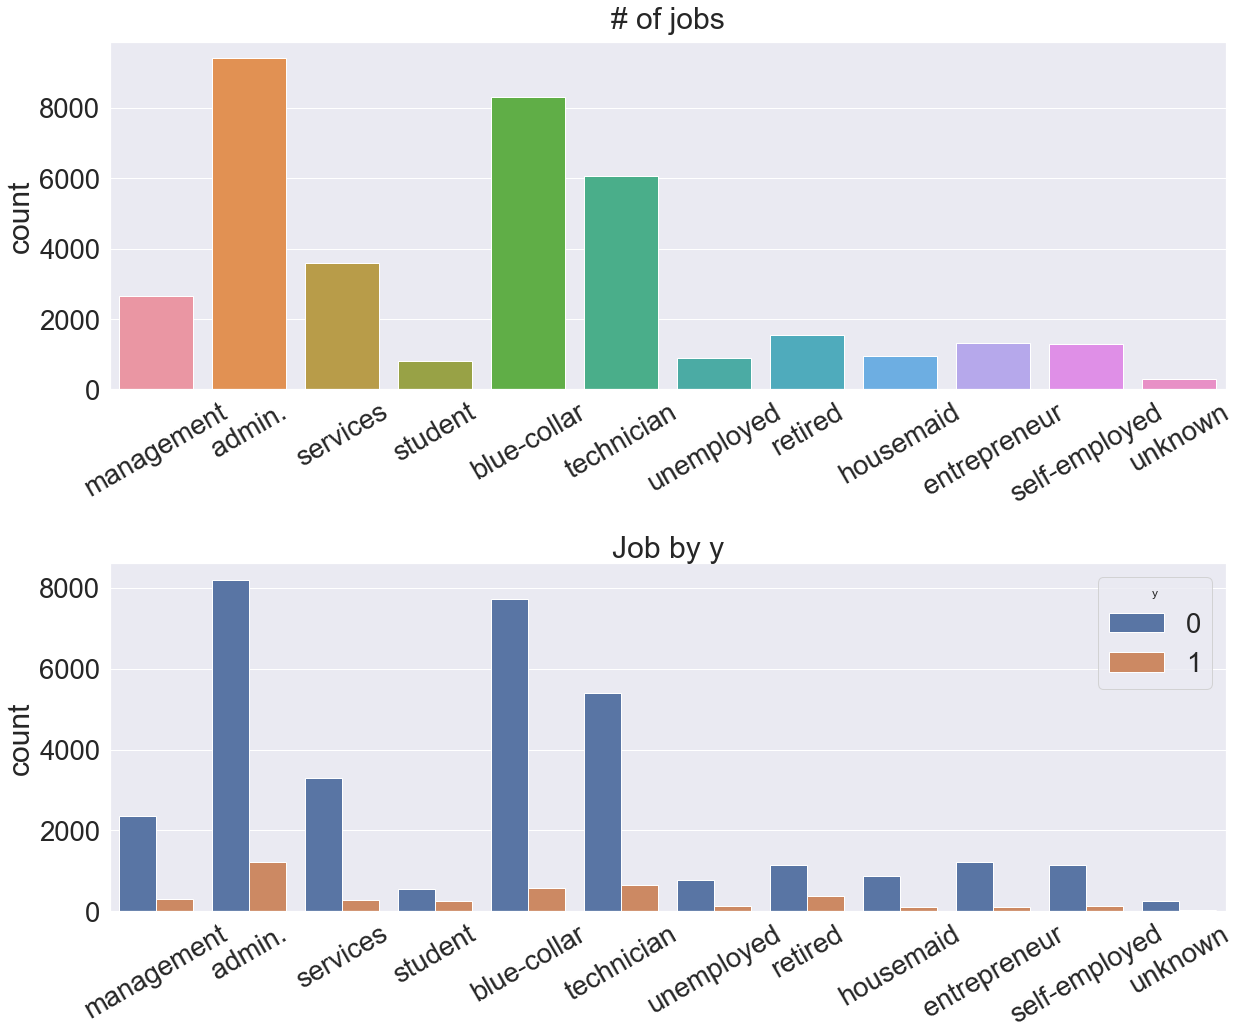

In [65]:
f, ax = plt.subplots(2,1,figsize=(20,16))
sns.countplot('job', data=df_train, ax=ax[0])
ax[0].set_xticklabels(labels=df_train['job'].unique(),rotation=30)
ax[0].set_title('# of jobs', y=1.02)
ax[0].set_xlabel('')

sns.countplot('job', hue='y', data=df_train, ax=ax[1])
ax[1].set_xticklabels(labels=df_train['job'].unique(),rotation=30)
plt.subplots_adjust(hspace=0.5)
ax[1].set_title('Job by y')
ax[1].set_xlabel('')
plt.show()

- Student와 retired 그룹에서 정기 예금 가입률이 높다.

### (3) Marital

In [66]:
pd.crosstab(df_train['marital'], df_train['y'], margins=True)

y,0,1,All
marital,,,
divorced,3709,424,4133
married,20166,2273,22439
single,8962,1469,10431
unknown,56,10,66
All,32893,4176,37069


In [67]:
df_train[['marital','y']].groupby('marital').mean().sort_values(by='y',ascending=False)

,y
marital,
unknown,0.151515
single,0.140830
divorced,0.102589
married,0.101297


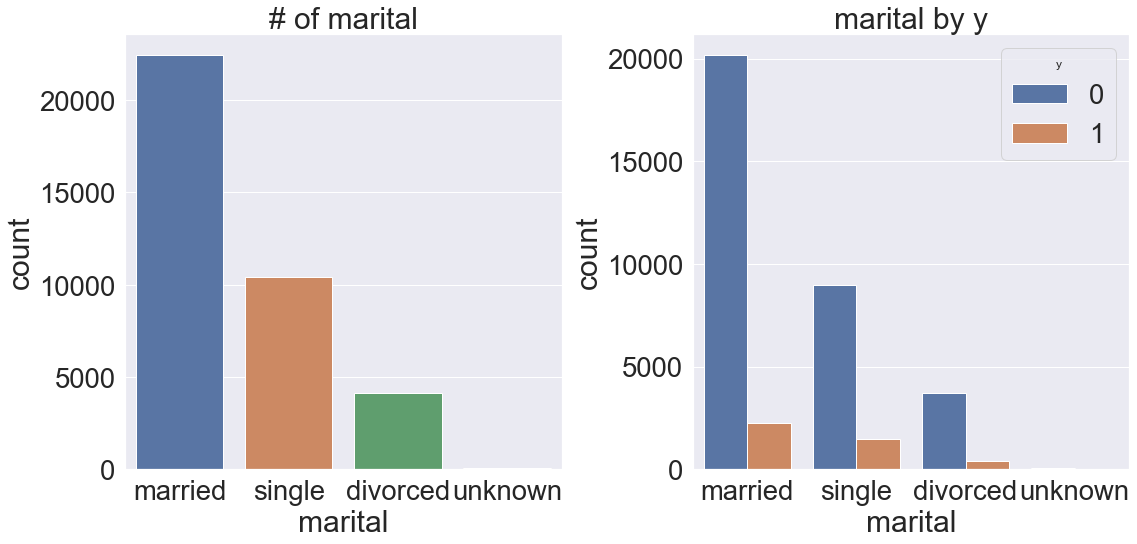

In [68]:
f, ax = plt.subplots(1,2,figsize=(18,8))
order=['married','single','divorced','unknown']
sns.countplot('marital', data=df_train, order=order, ax=ax[0])
ax[0].set_title('# of marital')

sns.countplot('marital', hue='y', data=df_train, order=order, ax=ax[1])
ax[1].set_title('marital by y')
plt.subplots_adjust(wspace=0.3)

- unknown의 수가 매우 적으며, 결혼 여부는 정기 예금 가입율에 큰 영향을 미치지 않는다. 단지 single일 때 소폭 높은 것을 확인 가능하다.

### (4) Education: 순서형 변수

In [345]:
pd.crosstab(df_train['education'], df_train['y'], margins=True)

y,0,1,All
education,,,
basic.4y,3379,378,3757
basic.6y,1880,176,2056
basic.9y,5001,428,5429
high.school,7624,939,8563
illiterate,14,4,18
professional.course,4206,536,4742
university.degree,9474,1489,10963
unknown,1315,226,1541
All,32893,4176,37069


In [379]:
df_train[['education','y']].groupby('education',as_index=False).mean().sort_values(by='education').T


,0,1,2,3,4,5,6,7
education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
y,0.100612,0.0856031,0.0788359,0.109658,0.222222,0.113032,0.13582,0.146658


- 교육수준별 정기예금가입율에 어느정도 차이가 나는 것을 알 수 있다.

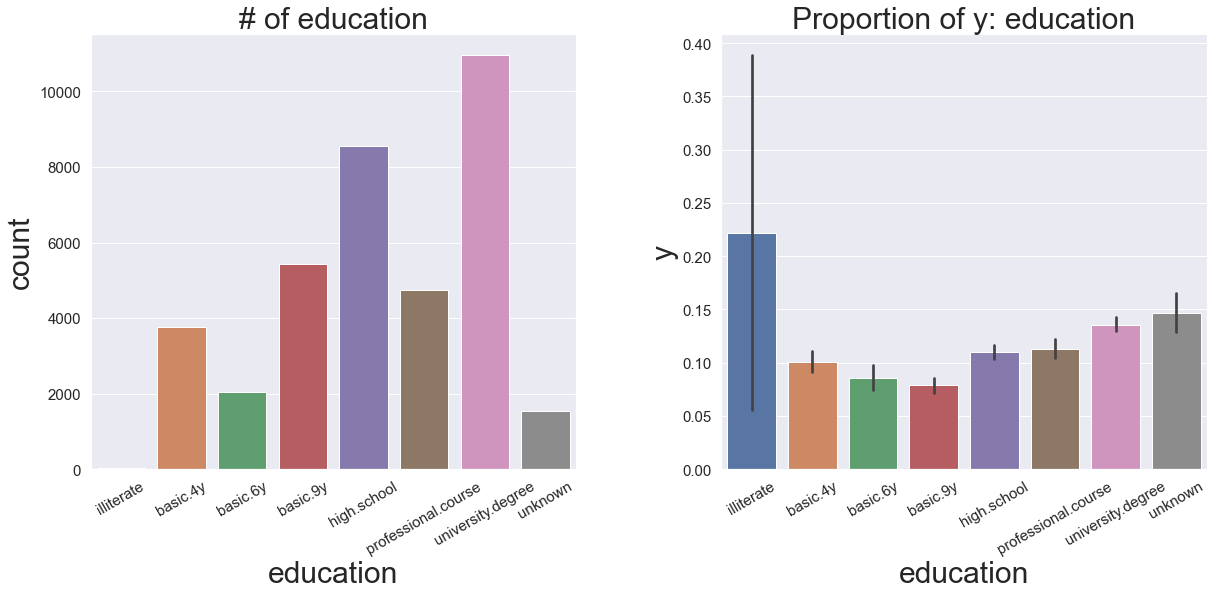

In [398]:
order = ['illiterate','basic.4y','basic.6y','basic.9y','high.school','professional.course','university.degree','unknown']
temp = df_train[['month','y']].groupby('month',as_index=False).mean()

f, ax = plt.subplots(1,2,figsize=(20,8))
sns.countplot('education', data=df_train, ax=ax[0], order=order)
ax[0].set_xticklabels(labels=order,rotation=30)
ax[0].set_title('# of education')
ax[0].tick_params(labelsize=15)

sns.barplot(x='education', y='y', data=df_train, ax=ax[1], order=order)
ax[1].set_xticklabels(labels=order,rotation=30)
ax[1].set_title('Proportion of y: education')
ax[1].tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

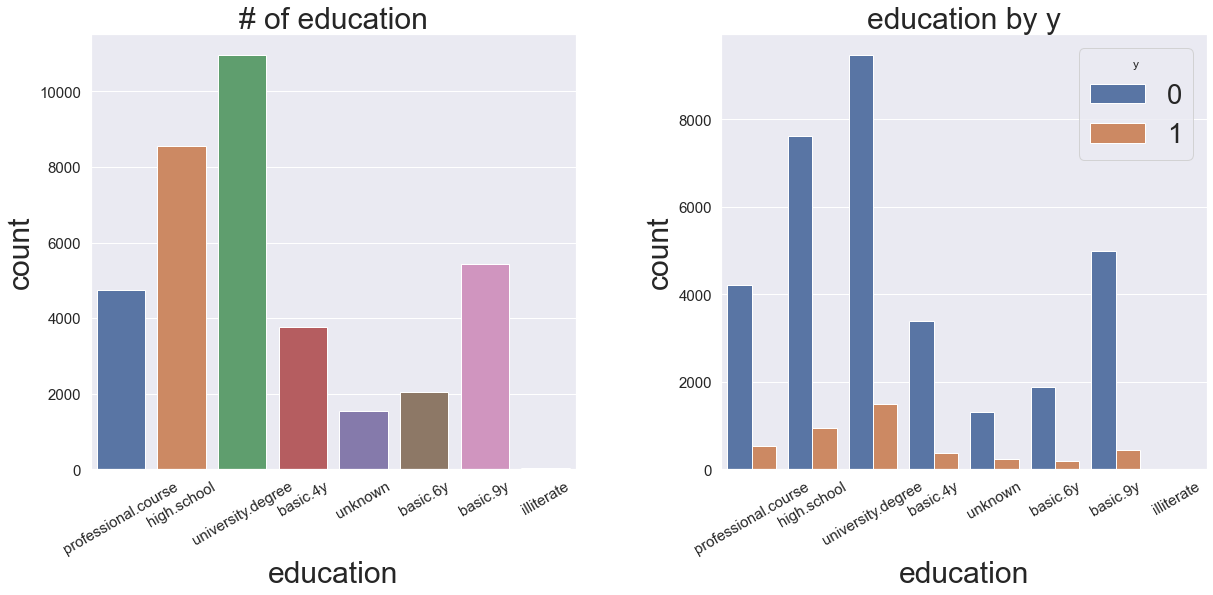

In [360]:
f, ax = plt.subplots(1,2,figsize=(20,8))
sns.countplot('education', data=df_train, ax=ax[0])
ax[0].set_xticklabels(labels=df_train['education'].unique(),rotation=30)
ax[0].set_title('# of education')
ax[0].tick_params(labelsize=15)

sns.countplot('education', hue='y', data=df_train, ax=ax[1])
ax[1].set_xticklabels(labels=df_train['education'].unique(),rotation=30)
ax[1].set_title('education by y')
ax[1].tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

### (5) Default

In [71]:
pd.crosstab(df_train['default'], df_train['y'], margins=True)

y,0,1,All
default,,,
no,25521,3770,29291
unknown,7369,406,7775
yes,3,0,3
All,32893,4176,37069


In [72]:
df_train[['default','y']].groupby('default').mean().sort_values(by='y',ascending=False)

,y
default,
no,0.128708
unknown,0.052219
yes,0.000000


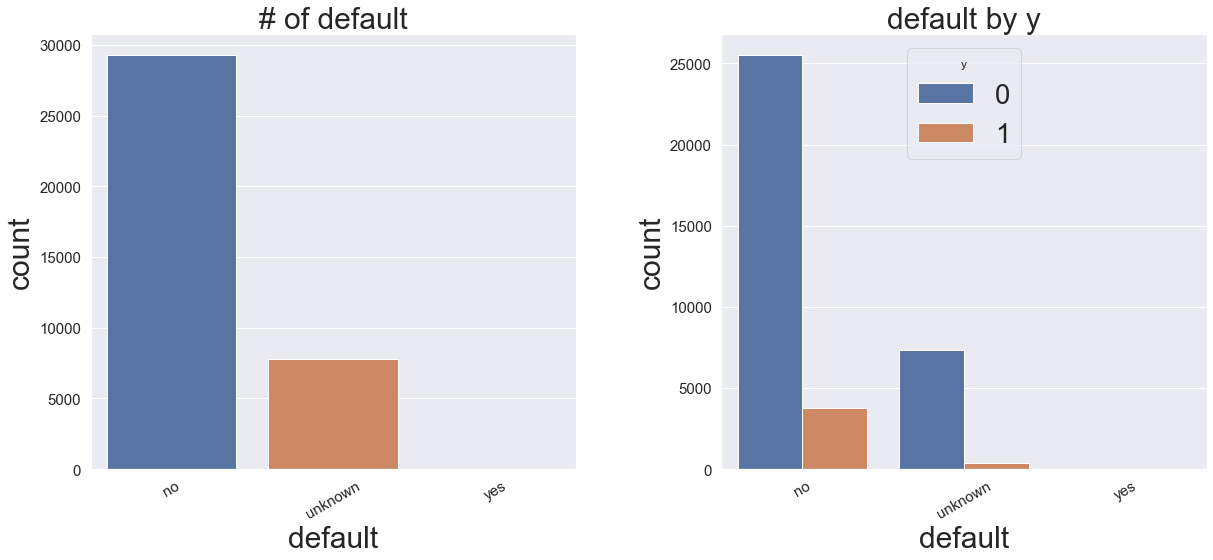

In [73]:
f, ax = plt.subplots(1,2,figsize=(20,8))
sns.countplot('default', data=df_train, ax=ax[0])
ax[0].set_xticklabels(labels=df_train['default'].unique(),rotation=30)
ax[0].set_title('# of default')
ax[0].tick_params(labelsize=15)

sns.countplot('default', hue='y', data=df_train, ax=ax[1])
ax[1].set_xticklabels(labels=df_train['default'].unique(),rotation=30)
ax[1].set_title('default by y')
ax[1].tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

- `default = 'yes'`는 3개의 값만 존재하며, 이는 전체 데이터의 0.009%에 불과하며 모두 y=0의 값을 갖고 있다.  
또한 나머지 값은 no 또는 unknown이기 때문에 실질적으로 이 변수는 y에 대한 정보를 주지 않고 있다고 볼 수 있다.
- 변수 제거를 고려한다.

In [74]:
df_train = df_train.loc[(df_train['default'] != 'yes')]
df_test = df_test.loc[(df_test['default'] != 'yes')]
print('train set: {}'.format(df_train.shape))
print('test set: {}'.format(df_test.shape))

train set: (37066, 21)
test set: (4119, 20)


### (6) Housing

In [75]:
df_train[['housing','y']].groupby('housing').mean().sort_values(by='y',ascending=False)

,y
housing,
yes,0.116232
no,0.108809
unknown,0.107420


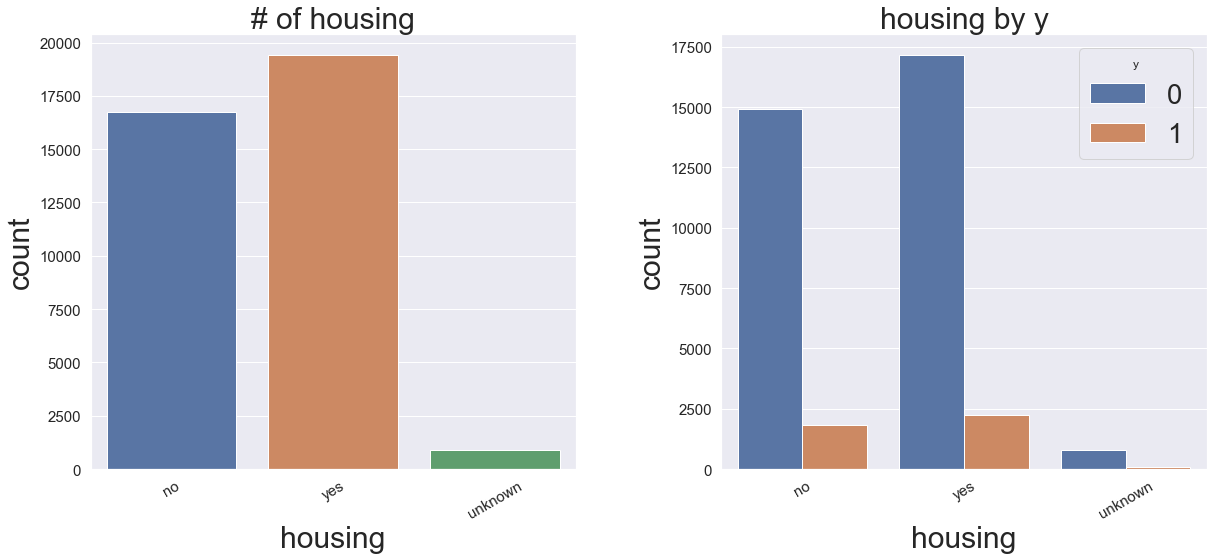

In [76]:
f, ax = plt.subplots(1,2,figsize=(20,8))
sns.countplot('housing', data=df_train, ax=ax[0])
ax[0].set_xticklabels(labels=df_train['housing'].unique(),rotation=30)
ax[0].set_title('# of housing')
ax[0].tick_params(labelsize=15)

sns.countplot('housing', hue='y', data=df_train, ax=ax[1])
ax[1].set_xticklabels(labels=df_train['housing'].unique(),rotation=30)
ax[1].set_title('housing by y')
ax[1].tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

- 주택 담보 대출 여부는 y에 영향을 거의 미치지 않는 것처럼 보인다.
- 이를 피어슨의 카이제곱 테스트로 검정해보기로 한다.

In [77]:
from scipy.stats import chi2_contingency

tabel = pd.crosstab(df_train['housing'], df_train['y'])
stat, p, dof, expected = chi2_contingency(tabel)
alpha = 0.05
if p <= alpha:
    print('Reject H0: independence')
else: print('Do not reject H0: independence')


Do not reject H0: independence


피어슨 카이제곱검정에서 유의수준 0.05하 housing과 y 간 독립이라는 귀무가설을 기각하지 못하므로 조금 더 통계적 확신을 갖고 housing feature를 제거할 수 있다.

In [34]:
# cols_to_test = ['housing','default','loan','job','marital','education']

# for cols in cols_to_test:
#     tabel = pd.crosstab(df_train[cols], df_train['y'])
#     stat, p, dof, expected = chi2_contingency(tabel)
#     alpha = 0.05
#     print("{},  p값: {}:".format(cols, round(p,2)))
#     if p <= alpha:
#         print('Reject H0: independence\n')
#     else: print('Do not reject H0: independence\n')

### (7) Loan

In [78]:
pd.crosstab(df_train['loan'], df_train['y'], margins=True)

y,0,1,All
loan,,,
no,27087,3448,30535
unknown,806,97,903
yes,4997,631,5628
All,32890,4176,37066


In [79]:
df_train[['loan','y']].groupby('loan').mean().sort_values(by='y',ascending=False)

,y
loan,
no,0.112920
yes,0.112118
unknown,0.107420


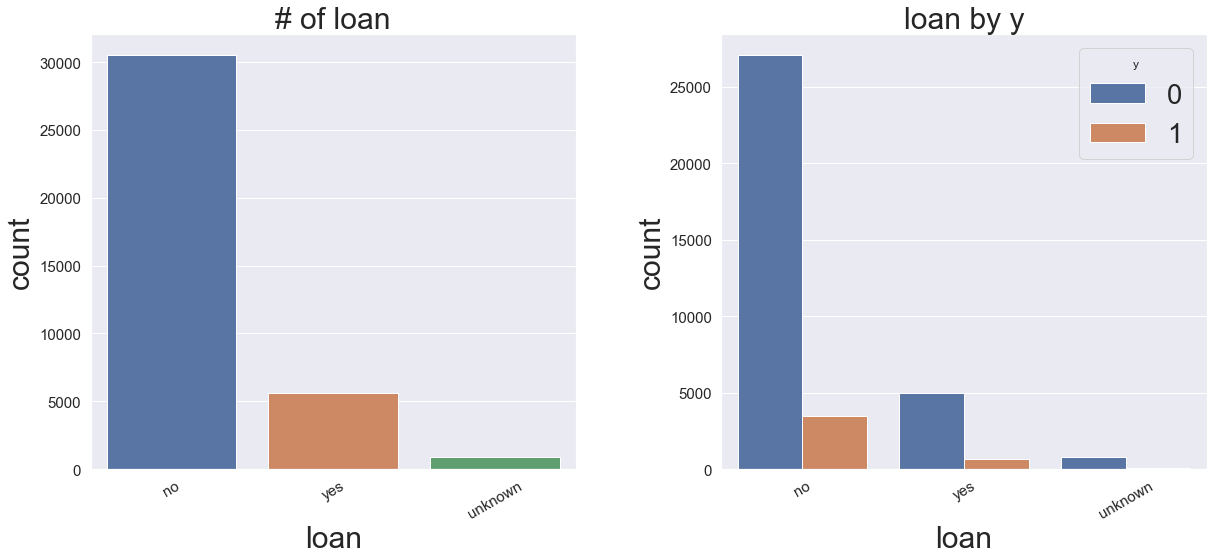

In [80]:
f, ax = plt.subplots(1,2,figsize=(20,8))
sns.countplot('loan', data=df_train, ax=ax[0])
ax[0].set_xticklabels(labels=df_train['loan'].unique(),rotation=30)
ax[0].set_title('# of loan')
ax[0].tick_params(labelsize=15)

sns.countplot('loan', hue='y', data=df_train, ax=ax[1])
ax[1].set_xticklabels(labels=df_train['loan'].unique(),rotation=30)
ax[1].set_title('loan by y')
ax[1].tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

- `loan`과 `housing`은 각 카테고리 별 y 비율의 차이가 없어 예측에 큰 도움이 되지 않을 수도 있다.

In [385]:
from scipy.stats import chi2_contingency
for col in ['housing', 'loan']:
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_train['loan'], df_train['y']))
    alpha = 0.05
    print("Pearson Chi-sq Test Result for {}:".format(col))
    if p <= alpha: print('Reject H0: independence\n')
    else: print('Do not reject H0: independence\n')

Pearson Chi-sq Test Result for housing:
Do not reject H0: independence

Pearson Chi-sq Test Result for loan:
Do not reject H0: independence



`loan`변수 역시 피어슨 카이제곱검정에서 유의수준 0.05하 loan과 y 간 독립이라는 귀무가설을 기각하지 못하므로 조금 더 통계적 확신을 갖고 loan feature를 제거할 수 있다.

## 2. EDA for Related with the last contact of the current campaign : 
Contact, Month, Day_of_week, Duration

### (1) Contact

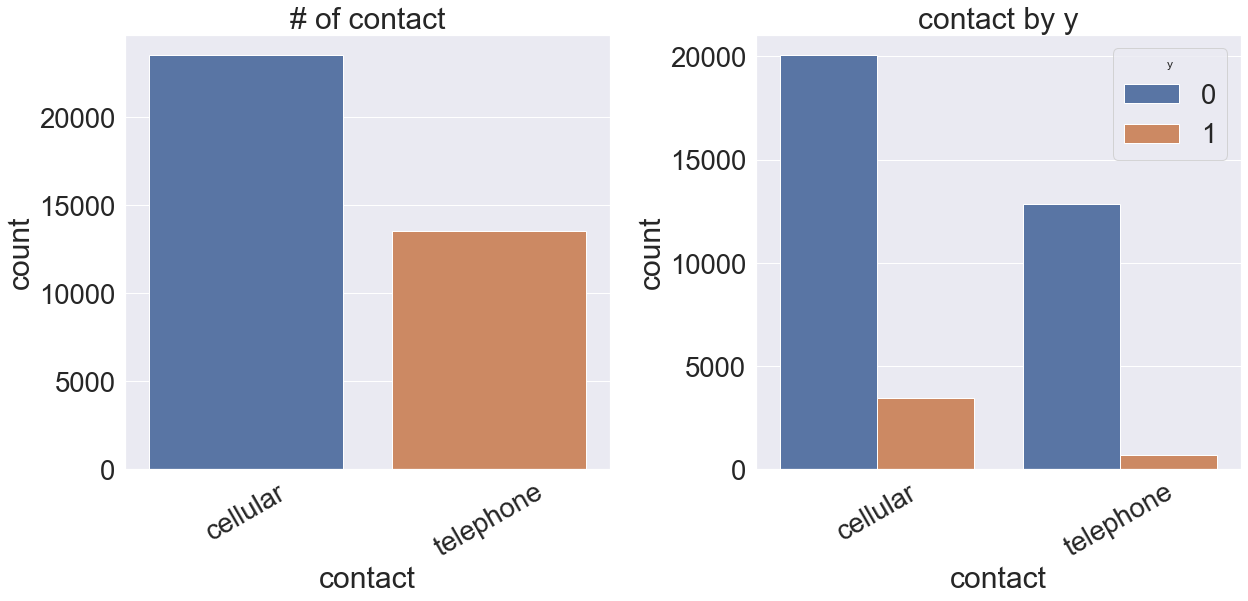

In [82]:
f, ax = plt.subplots(1,2,figsize=(20,8))
sns.countplot('contact', data=df_train, ax=ax[0])
ax[0].set_xticklabels(labels=df_train['contact'].unique(),rotation=30)
ax[0].set_title('# of contact')

sns.countplot('contact', hue='y', data=df_train, ax=ax[1])
ax[1].set_xticklabels(labels=df_train['contact'].unique(),rotation=30)
ax[1].set_title('contact by y')
plt.subplots_adjust(wspace=0.3)

In [83]:
df_train[['contact','y']].groupby('contact').mean()

,y
contact,
cellular,0.147346
telephone,0.052472


contact의 종류에 따라 y의 비율 차이가 크게 나므로 좋은 예측변수가 되리라 생각한다.

### (2) Month

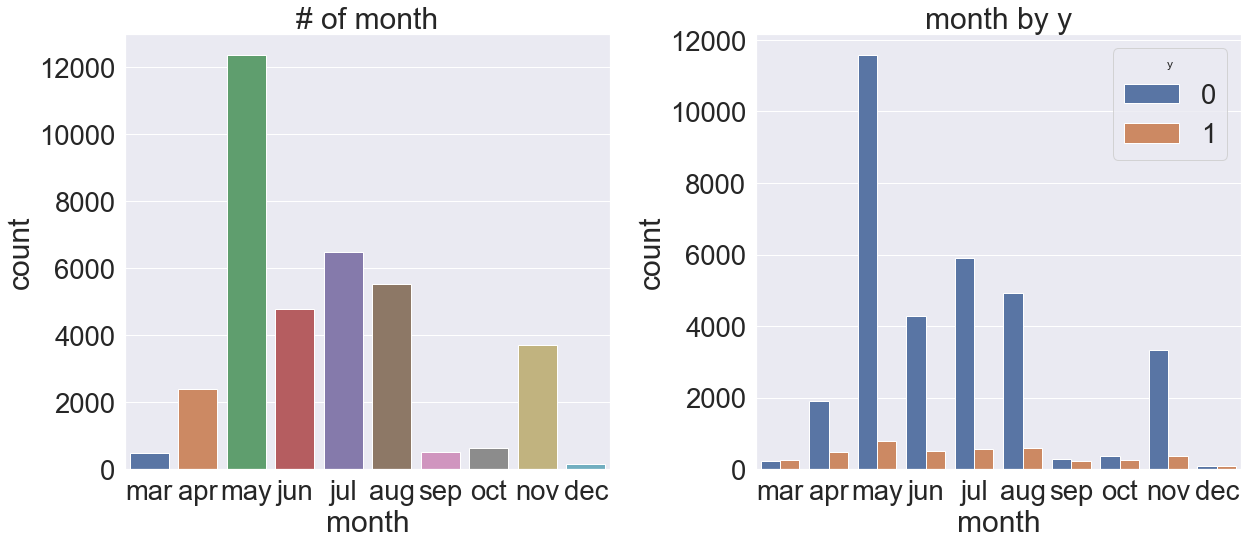

In [386]:
order = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
f, ax = plt.subplots(1,2,figsize=(20,8))
sns.countplot('month', data=df_train, ax=ax[0], order=order)
ax[0].set_title('# of month')

sns.countplot('month', hue='y', data=df_train, ax=ax[1], order=order)
ax[1].set_title('month by y')
plt.subplots_adjust(wspace=0.3)

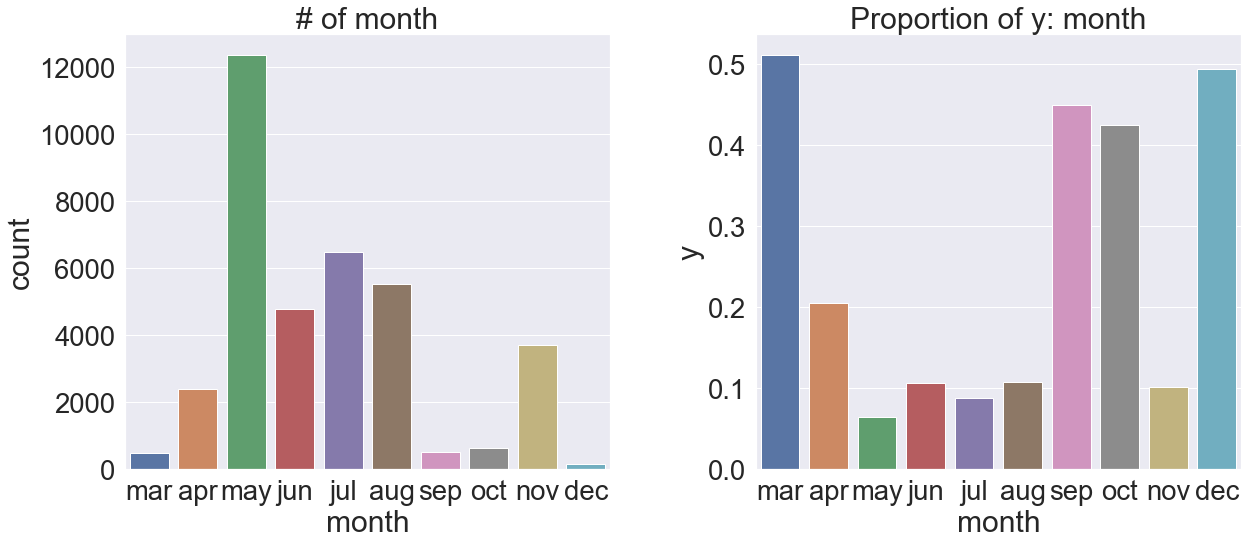

In [395]:
temp = df_train[['month','y']].groupby('month',as_index=False).mean()
f, ax = plt.subplots(1,2,figsize=(20,8))
sns.countplot('month', data=df_train, ax=ax[0], order=order)
ax[0].set_title('# of month')

sns.barplot(x='month', y='y', data=temp, order=order,ax=ax[1])
ax[1].set_title('Proportion of y: month')
plt.subplots_adjust(wspace=0.3)

Text(0.5, 1.0, 'Proportion of y: month')

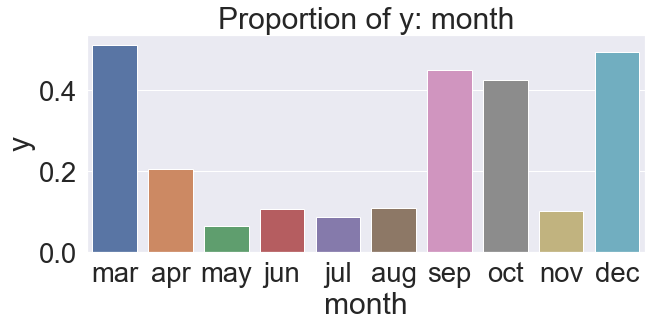

In [392]:
plt.figure(figsize=(10,4))
temp = df_train[['month','y']].groupby('month',as_index=False).mean()
sns.barplot(x='month', y='y', data=temp, order=order)
plt.title('Proportion of y: month')

In [388]:
df_train[['month','y']].groupby('month').mean().sort_values(by='y')

,y
month,
may,0.063981
jul,0.088044
nov,0.101512
jun,0.106463
aug,0.108201
apr,0.205514
oct,0.424572
sep,0.450292
dec,0.494186


- 1월과 2월에는 데이터가 없다.
- 대부분의 전화횟수가 may(5월)에 몰려있다.
- oct(10월), mar(3월), sep(9월), dec(12월)은 상대적으로 적은 통화량이나 마케팅이 성공(y=1)일 확률이 매우 높다.
- 그러므로 좋은 feature라고 예상된다.

### (3) Day Of Week

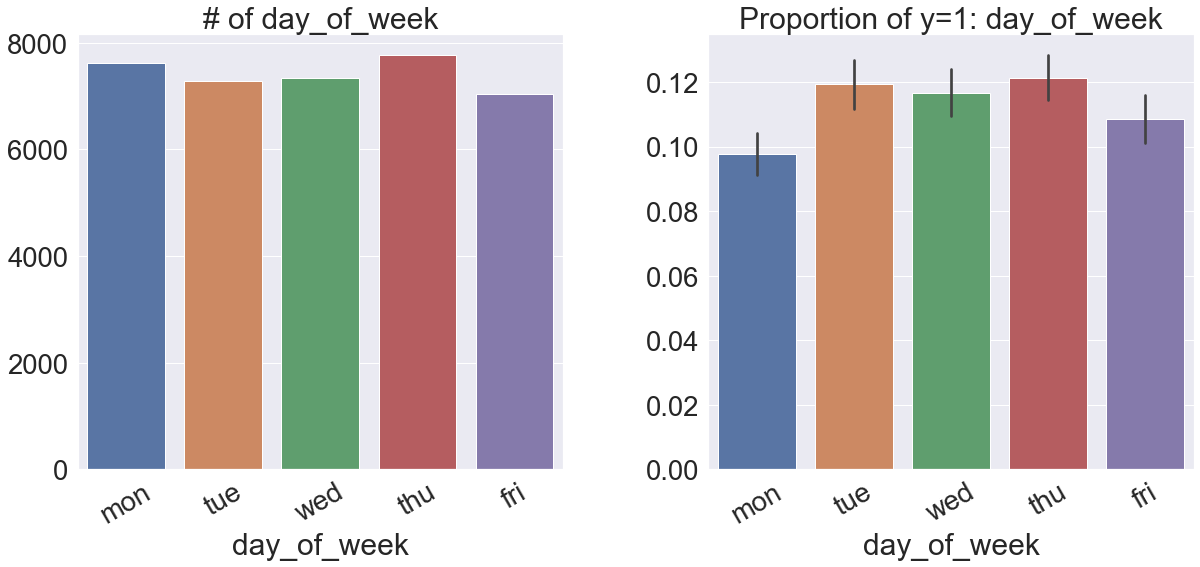

In [403]:
order=['mon','tue','wed','thu','fri']
temp = df_train[['day_of_week','y']].groupby('day_of_week').mean()

f, ax = plt.subplots(1,2,figsize=(20,8))

sns.countplot('day_of_week', data=df_train, ax=ax[0], order=order)
ax[0].set_xticklabels(labels=order,rotation=30)
ax[0].set_title('# of day_of_week')
ax[0].set_ylabel('')

sns.barplot(x='day_of_week', y='y', data=df_train, ax=ax[1], order=order)
ax[1].set_xticklabels(labels=order,rotation=30)
ax[1].set_title('Proportion of y=1: day_of_week')
ax[1].set_ylabel('')
plt.subplots_adjust(wspace=0.3)

In [89]:
df_train[['day_of_week','y']].groupby('day_of_week').mean().sort_values(by='y')

,y
day_of_week,
mon,0.097679
fri,0.108461
wed,0.116637
tue,0.119335
thu,0.121173


In [404]:
from scipy.stats import chi2_contingency

tabel = pd.crosstab(df_train['day_of_week'], df_train['y'])
stat, p, dof, expected = chi2_contingency(tabel)
alpha = 0.05
if p <= alpha:
    print('Reject H0: independence')
else: print('Do not reject H0: independence')

Reject H0: independence


- 주말에는 마케팅을 진행하지 않았다.
- 요일에 따라 y의 비율은 큰 차이가 없지만, 목요일에 가장 성공률이 높다.

### (4) Duration

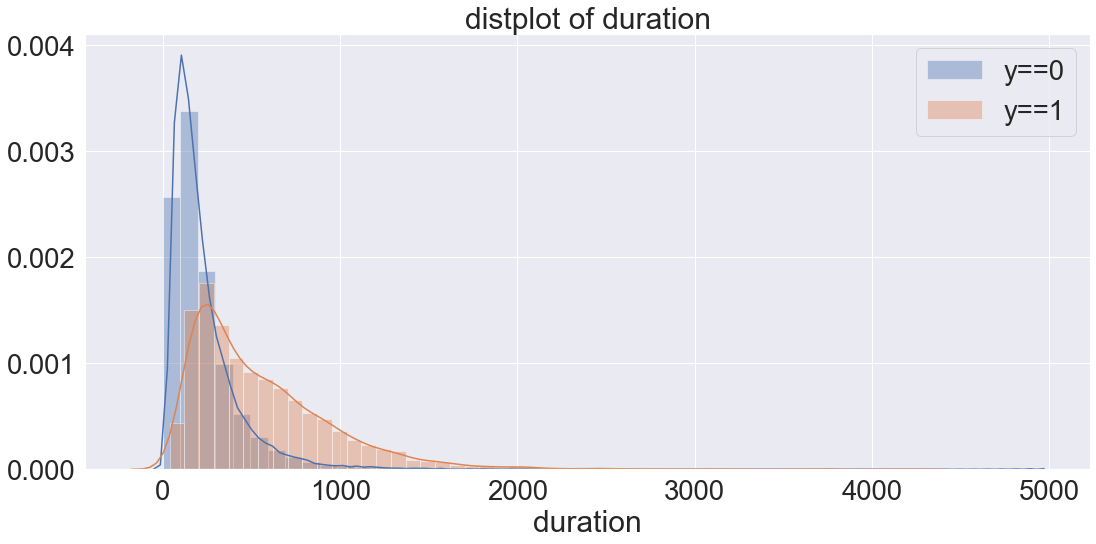

In [467]:
plt.figure(figsize=(18,8))
sns.distplot(df_train.loc[df_train['y']==0,'duration'], label='y==0')
sns.distplot(df_train.loc[df_train['y']==1,'duration'], label='y==1')
plt.title('distplot of duration')
plt.legend()

## 3. Other attributes

In [91]:
others = ['campaign', 'pdays', 'previous', 'poutcome','y']
df_other = df_train[others]
df_other.describe()

,campaign,pdays,previous,y
count,37066.000000,37066.000000,37066.000000,37066.000000
mean,2.574030,962.139076,0.173690,0.112664
std,2.794492,187.732505,0.495053,0.316186
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,999.000000,0.000000,0.000000
50%,2.000000,999.000000,0.000000,0.000000
75%,3.000000,999.000000,0.000000,0.000000
max,56.000000,999.000000,6.000000,1.000000


### (1) Campaign

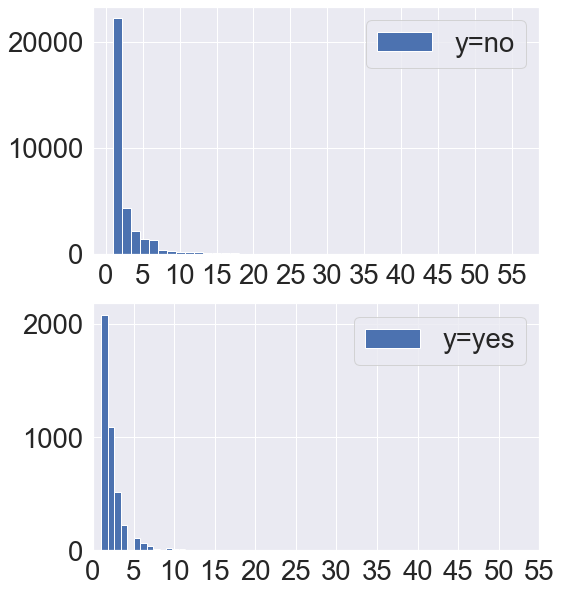

In [479]:
f, ax = plt.subplots(2,1,figsize=(8,10))
ax[0].hist(df_train.loc[df_train['y']==0,'campaign'], bins=45, label='y=no')
ax[0].set_xticks(range(0,60,5))
ax[0].legend()

ax[1].hist(df_train.loc[df_train['y']==1,'campaign'], bins=20, label='y=yes')
ax[1].set_xticks(range(0,60,5))
ax[1].legend()
plt.show()

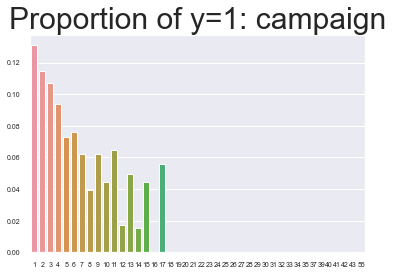

In [484]:
temp = df_train[['campaign', 'y']].groupby('campaign',as_index=False).mean()
sns.barplot(x='campaign', y='y',data=temp)
plt.tick_params(labelsize=7)
plt.ylabel('')
plt.xlabel('')
plt.title('Proportion of y=1: campaign')
plt.show()


`campaign`은 이번 마케팅 기간 동안 고객에게 연락한 횟수를 뜻하는데, 한 번의 마케팅에서 수차례 전화를 하는 것은 상품 가입율을 떨어뜨릴 것이라는 예상이 가능하다. 이처럼 실제 데이터도 그러한 경향을 보이고 있으며, 상식 선에서 15회 이상의 마케팅 연락은 이상치라고 여길 수도 있다.

Text(0.5, 1.0, 'Box plot: campaign')

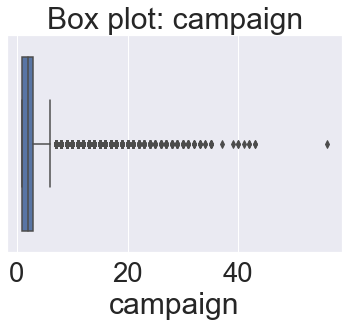

In [483]:
sns.boxplot('campaign',data=df_train, orient='h')
plt.title('Box plot: campaign')

IQR를 사용한 이상치 제거

In [486]:
print('Outliers: above {} values are outliers'.format(df_train['campaign'].quantile(q=0.75) + 1.5*df_train['campaign'].quantile(q=0.75)))

Outliers: above 7.5 values are outliers


반올림하여 8회보다 큰 값들을 이상치로 여기고 제거한다.

In [487]:
temp = df_train.copy()
print('outlier 제거 전 train shape: {}'.format(temp.shape))
temp = temp.loc[(df_train['campaign']<=8)]

print('outlier 제거 후 train shape: {}'.format(temp.shape))

outlier 제거 전 train shape: (37069, 21)
outlier 제거 후 train shape: (35821, 21)


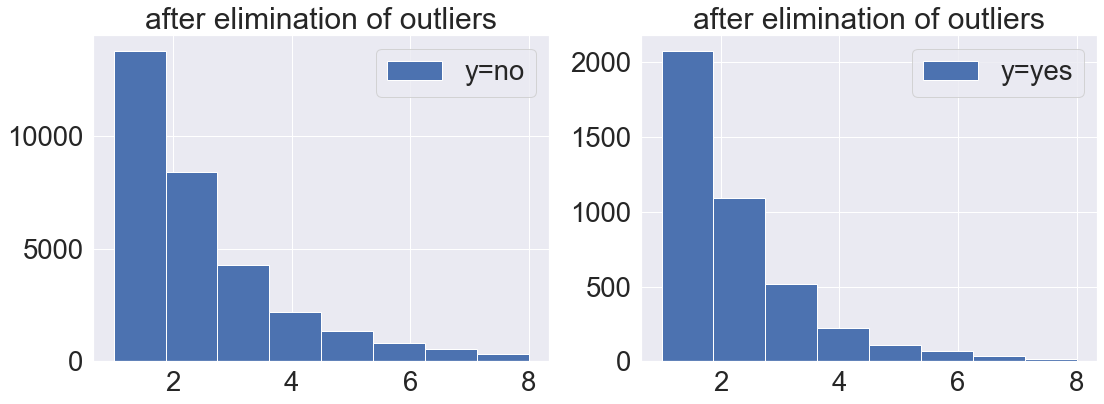

In [489]:
f, ax = plt.subplots(1,2,figsize=(18,6))
temp.loc[temp['y']==0,'campaign'].plot.hist(ax=ax[0], bins=8)
ax[0].set_ylabel('')
ax[0].set_title('after elimination of outliers')
ax[0].legend(['y=no'])

temp.loc[temp['y']==1,'campaign'].plot.hist(ax=ax[1], bins=8)
ax[1].set_ylabel('')
ax[1].set_title('after elimination of outliers')
ax[1].legend(['y=yes'])
plt.show()

### (2) pdays

In [98]:
df_train['pdays'].unique()

array([999,   3,   6,   8,   7,  10,  17,   9,   4,  11,  18,  12,  22,
         2,   5,   1,  19,   0,  15,  13,  16,  14,  25,  27,  26,  21],
      dtype=int64)

`pdays`는 이전 마케팅에서 고객에게 마지막으로 연락한 후 경과한 일수지만, 대부분의 값이 999로 고객과 이전에 연락한 적이 없음을 뜻한다.

In [99]:
pd.crosstab(df_train['pdays'], df_train['y'])

y,0,1
pdays,,
0,5,9
1,17,6
2,23,33
3,117,271
4,49,56
5,13,27
6,109,272
7,18,39
8,6,12


- 그러므로 이항변수로 만들어주는 것이 도움이 될 것이라 생각한다.

In [516]:
temp = df_train.copy()
def cut_pdays(x):
    if x==999: return 0
    else: return 1
    
temp['pdays_cat'] = temp['pdays'].map(cut_pdays)

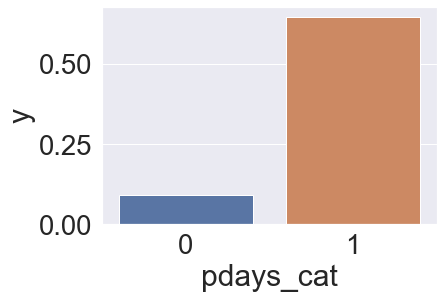

In [503]:
temp = temp[['pdays_cat','y']].groupby('pdays_cat', as_index=False).mean()
sns.barplot(x='pdays_cat', y='y', data=temp)

### (3) Previous

`previous`는 순서형 변수인데, 아래 교차표에서 보듯 2이상의 값에서 y의 비율이 높다.

In [102]:
df_train['previous'].unique()

array([0, 1, 3, 2, 4, 5, 6], dtype=int64)

In [103]:
pd.crosstab(df_train['previous'], df_train['y'])

y,0,1
previous,,
0,29179,2805
1,3231,886
2,366,316
3,79,119
4,29,37
5,4,11
6,2,2


Text(0.5, 1.0, 'previous: proportion of y=1')

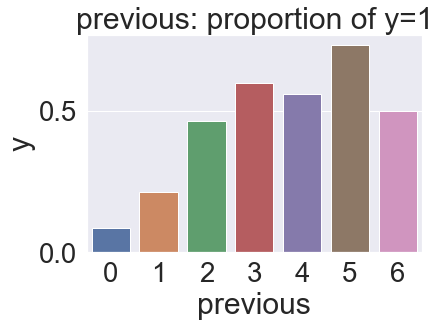

In [104]:
temp = df_train[['previous', 'y']].groupby('previous', as_index=False).mean()
sns.barplot(x='previous', y='y', data=temp)
plt.title('previous: proportion of y=1')

- 그러므로 previous가 2보다 크면 1 아니면 0을 갖는 이항변수를 생성한다.

### (4) Poutcome

Text(0.5, 1.0, 'poutcome: proportion of y=1')

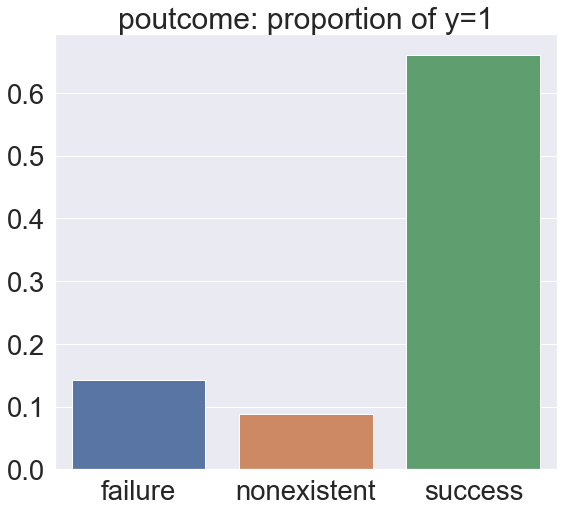

In [510]:
temp = df_train[['poutcome', 'y']].groupby('poutcome', as_index=False).mean()
plt.figure(figsize=(9,8))
sns.barplot(x='poutcome', y='y', data=temp)
plt.ylabel('')
plt.xlabel('')
plt.title('poutcome: proportion of y=1')

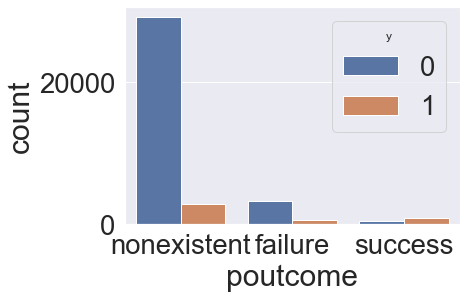

In [105]:
sns.countplot('poutcome', hue='y', data=df_train)

In [106]:
df_train.poutcome.unique()

array(['nonexistent', 'failure', 'success'], dtype=object)

In [107]:
# df_train['poutcome_cat'] = df_train['poutcome'].map({'failure':0,'nonexistent':0,
#                                                     'success':1})
# df_test['poutcome_cat'] = df_test['poutcome'].map({'failure':0,'nonexistent':0,
#                                                     'success':1})

# df_train.drop('poutcome', axis=1, inplace=True)
# df_test.drop('poutcome', axis=1, inplace=True)

## 4. EDA for Social and economic context attributes

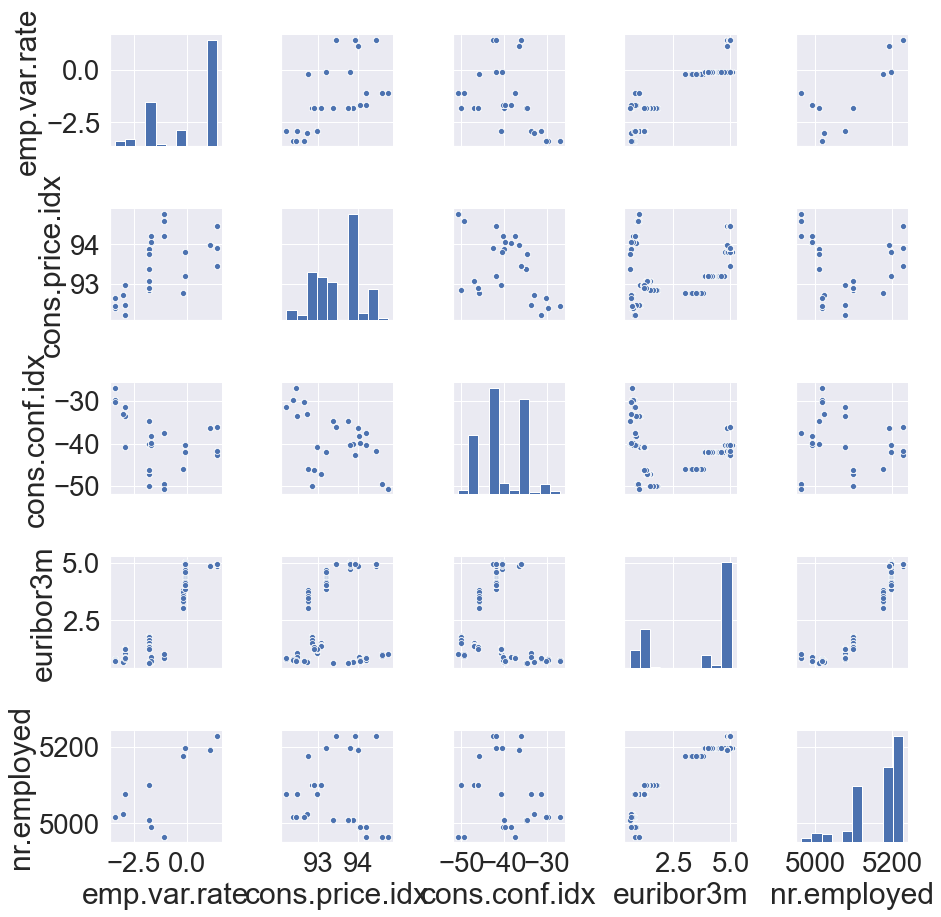

In [108]:
context_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
sns.pairplot(df_train[context_cols])

In [109]:
df_train[context_cols].corr()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
emp.var.rate,1.000000,0.776999,0.194333,0.972313,0.907141
cons.price.idx,0.776999,1.000000,0.058233,0.690020,0.524561
cons.conf.idx,0.194333,0.058233,1.000000,0.275865,0.098770
euribor3m,0.972313,0.690020,0.275865,1.000000,0.945269
nr.employed,0.907141,0.524561,0.098770,0.945269,1.000000


- `emp.var.rate	`와 `euribor3m`: 0.972313	
- `emp.var.rate` 와 `nr.employed` : 0.907141
- `euribor3m` 과 `nr.employed` : 0.945269  
로 매우 높은 상관관계를 보이고 있다. 추후 PCA를 통해 차원축소를 고려해본다.

### PCA for Social and economic context attributes

In [143]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
context_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

std = StandardScaler()
pca = PCA(n_components=3)
temp = df_train[context_cols]
temp_std = std.fit_transform(temp)
temp_pca = pca.fit_transform(temp_std)
print("Expained variance ratio: {}".format(sum(pca.explained_variance_ratio_)))

Expained variance ratio: 0.9928977633093522


In [144]:
pca.explained_variance_ratio_

array([0.69377041, 0.19661543, 0.10251192])

- 5개 중 3개의 주성분만으로도 99%의 분산을 설명하므로, 3개의 주성분을 사용하기로 했다.

## Final Preprocessing and Base Modeling

In [23]:
# Load data
df = pd.read_csv('bank.csv', sep=';')
from sklearn.preprocessing import LabelEncoder
le_y = LabelEncoder()
df['y'] = le_y.fit_transform(df['y'])
print(le_y.classes_)    # le_y의 classes_
print(le_y.inverse_transform([0,1]))
df.head()
X = df.drop('y', axis=1)
y = df['y']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12, test_size=0.1)

# train set & test set 생성
df_train = X_train
df_train['y'] = y_train
df_train = df_train.reset_index(drop=True)

df_test = X_test
df_test['y'] = y_test
df_test = X_test.reset_index(drop=True)

['no' 'yes']
['no' 'yes']


(0) remove outliers contain `campaign > 8`

In [24]:
df_train = df_train.loc[(df_train['campaign']<=8)]
df_test = df_test.loc[(df_test['campaign']<=8)]

(1) cut_age

In [25]:
def cut_age(x):
    if x<=30: return 0
    elif x<=60: return 1
    else: return 2
    
df_train['age_cat'] = df_train['age'].map(cut_age)
df_test['age_cat'] = df_test['age'].map(cut_age)

(3) cut_pdays

In [26]:
def cut_pdays(x):
    if x==999: return 0
    else: return 1
    
df_train['pdays_cat'] = df_train['pdays'].map(cut_pdays)
df_test['pdays_cat'] = df_test['pdays'].map(cut_pdays)

df_train.drop(['pdays'], axis=1, inplace=True)
df_test.drop(['pdays'], axis=1, inplace=True)

(4) cut_previous

In [27]:
df_train['previous'] = df_train['previous'].map(lambda x: 1 if x>=2 else 0)
df_test['previous'] = df_test['previous'].map(lambda x: 1 if x>=2 else 0)

(5) cat_poutcome

In [28]:
df_train['poutcome_cat'] = df_train['poutcome'].map({'failure':0,'nonexistent':0,
                                                    'success':1})
df_test['poutcome_cat'] = df_test['poutcome'].map({'failure':0,'nonexistent':0,
                                                    'success':1})

df_train.drop('poutcome', axis=1, inplace=True)
df_test.drop('poutcome', axis=1, inplace=True)

- 이제 순서형 변수, 명목형 변수에 대한 전처리를 시행한다.  
순서형: `education`, `campaign` , `previous`, `age_cat`  
명목형: `job`, `marital`, `contact`,`month`, `day_of_week`, `previous`, `poutcome_cat`, `pdays_cat`  
연속형: `duration`, `emp.var.rate`,`cons.price.idx`, `cons.conf.idx`, `nr.employed`

In [29]:
# 앞서 unknown은 university.degree와 target의 비율이 비슷한 점을 이용
df_train['education'] = df_train['education'].map({'illiterate':1, 'basic.4y':2, 'basic.6y':3, 
                           'basic.9y':4, 'high.school':5, 'professional.course':6,
                          'university.degree':7, 'unknown':7})
df_test['education'] = df_test['education'].map({'illiterate':1, 'basic.4y':2, 'basic.6y':3, 
                           'basic.9y':4, 'high.school':5, 'professional.course':6,
                          'university.degree':7, 'unknown':7})

In [30]:
df_train = pd.get_dummies(data = df_train, columns = ['job'] , prefix = ['job'], drop_first=True)
df_train = pd.get_dummies(data = df_train, columns = ['marital'] , prefix = ['marital'], drop_first=True)
df_train = pd.get_dummies(data = df_train, columns = ['contact'] , prefix = ['contact'], drop_first=True)
df_train = pd.get_dummies(data = df_train, columns = ['month'] , prefix = ['month'], drop_first=True)
df_train = pd.get_dummies(data = df_train, columns = ['day_of_week'] , prefix = ['day_of_week'], drop_first=True)

In [31]:
df_test = pd.get_dummies(data = df_test, columns = ['job'] , prefix = ['job'], drop_first=True)
df_test = pd.get_dummies(data = df_test, columns = ['marital'] , prefix = ['marital'], drop_first=True)
df_test = pd.get_dummies(data = df_test, columns = ['contact'] , prefix = ['contact'], drop_first=True)
df_test = pd.get_dummies(data = df_test, columns = ['month'] , prefix = ['month'], drop_first=True)
df_test = pd.get_dummies(data = df_test, columns = ['day_of_week'] , prefix = ['day_of_week'], drop_first=True)

- log transformation & standardization for duration 

In [32]:
df_train['duration'] = df_train['duration'].map(lambda x: np.log(x) if x>0 else 0)
df_test['duration'] = df_test['duration'].map(lambda x: np.log(x) if x>0 else 0)

In [33]:
from sklearn.preprocessing import StandardScaler

std_du = StandardScaler()
df_train['duration'] = std_du.fit_transform(df_train[['duration']])
df_test['duration'] = std_du.transform(df_test[['duration']])

- PCA for Social and economic context attributes

Expained variance ratio: 0.9928977633093574


Text(0.5, 1.0, 'elbow plot')

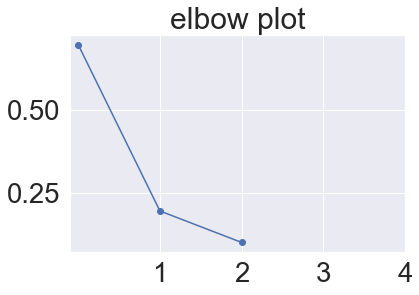

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
context_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

std = StandardScaler()
pca = PCA(n_components=3)
temp = df_train[context_cols]
temp_te = df_test[context_cols]
temp_std = std.fit_transform(temp)
temp_te_std = std.transform(temp_te)
temp_pca = pca.fit_transform(temp_std)
temp_te_pca = pca.transform(temp_te_std)
print("Expained variance ratio: {}".format(sum(pca.explained_variance_ratio_)))
plt.plot(pca.explained_variance_ratio_,'o-')
plt.xticks(range(1,5,1))
plt.title('elbow plot')

In [35]:
df_train = pd.concat([df_train.reset_index(drop=True),pd.DataFrame(temp_pca)], axis=1)
df_test = pd.concat([df_test.reset_index(drop=True),pd.DataFrame(temp_te_pca)], axis=1)

- drop unneccesary columns: ['default', 'housing', 'loan', 'age']

In [36]:
cols_to_drop = ['default', 'housing', 'loan', 'age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
df_train.drop(cols_to_drop, axis=1, inplace=True)
df_test.drop(cols_to_drop, axis=1, inplace=True)

In [37]:
# 최종 Train Set과 Test Set
X = df_train.drop(['y'], axis=1)
y = df_train['y']
X_test = df_test.drop(['y'], axis=1)
y_test = df_test['y']

In [38]:
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(35821, 38)
(3990, 38)
(35821,)
(3990,)


In [64]:
# 현재까지의 데이터를 train set과 validation set으로 분리
from sklearn.model_selection import train_test_split
X_tr, X_vld, y_tr, y_vld = train_test_split(X, y, stratify=y, random_state=0, test_size=0.2)
X_tr.head()

,education,duration,campaign,previous,age_cat,pdays_cat,poutcome_cat,job_blue-collar,job_entrepreneur,job_housemaid,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,0,1,2
34676,7,-1.401173,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-1.493574,-0.657176,-0.157300
23453,7,0.013376,2,0,1,1,1,0,0,0,...,0,0,0,1,0,0,0,2.279162,1.367582,1.861848
24422,5,-0.497073,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,2.416190,-0.890515,-0.351415
34819,7,-0.247025,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,-1.333766,0.874128,-0.672094
7625,7,0.900021,4,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,-1.340097,0.692931,0.382480


## (2) SMOTE

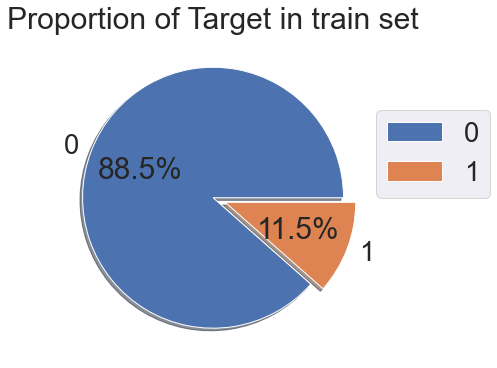

In [162]:
plt.figure(figsize=(6,6))
y_tr.value_counts().plot.pie(explode=[0,0.1], shadow=True, autopct='%1.1f%%')
plt.legend(loc=(1,0.5))
plt.title('Proportion of Target in train set')
plt.ylabel('')
plt.show()

- 앞에서 보았듯이 Target variable y는 88.5%가 0을 갖는 불균형한 데이터다. 이를 SMOTE를 이용해 처리해주기로 한다.

In [163]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_tr_smote, y_tr_smote = smote.fit_resample(X_tr,y_tr)

In [164]:
print('SMOTE 적용 전 Train data set: ', X_tr.shape, y_tr.shape)
print('SMOTE 적용 후 Train data set: ', X_tr_smote.shape, y_tr_smote.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_tr).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_tr_smote).value_counts())

SMOTE 적용 전 Train data set:  (28656, 38) (28656,)
SMOTE 적용 후 Train data set:  (50706, 38) (50706,)
SMOTE 적용 전 레이블 값 분포: 
 0    25353
1     3303
Name: y, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 1    25353
0    25353
Name: y, dtype: int64


## Model Comparison by smote & time

### (1) KNN: KNN데이터 생성

- SMOTE 적용 전 train set과 valid set 정확도

In [165]:
acu_list = []; acu_sm_list = []
pre_list = []; pre_sm_list = []
recall_list = []; recall_sm_list = []
f1_list = []; f1_sm_list = []

In [166]:
import time
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

fit_start = time.perf_counter()
knn.fit(X_tr, y_tr)
fit_end = time.perf_counter()

pred_start = time.perf_counter()
y_pred_knn = knn.predict(X_vld)
pred_end = time.perf_counter()

knn_time_fit = fit_end - fit_start
knn_time_pred = pred_end - pred_start

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_knn)))
acu_list.append(round(accuracy_score(y_vld,y_pred_knn),3))
pre_list.append(round(precision_score(y_vld,y_pred_knn),3))
recall_list.append(round(recall_score(y_vld,y_pred_knn),3))
f1_list.append(round(f1_score(y_vld, y_pred_knn),3))

Confusion Matrix:
[[6137  202]
 [ 491  335]]


- SMOTE 적용 후 train set과 valid set 정확도:  
f1-score가 증가한다. 특히 Recall이 크게 증가한다.

In [167]:
knn = KNeighborsClassifier()
knn.fit(X_tr_smote, y_tr_smote)
y_pred_knn = knn.predict(X_vld)

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_knn)))
acu_sm_list.append(round(accuracy_score(y_vld,y_pred_knn),3))
pre_sm_list.append(round(precision_score(y_vld,y_pred_knn),3))
recall_sm_list.append(round(recall_score(y_vld,y_pred_knn),3))
f1_sm_list.append(round(f1_score(y_vld, y_pred_knn),3))

Confusion Matrix:
[[5447  892]
 [ 175  651]]


### (2) Logistic Regression

In [168]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()

fit_start = time.perf_counter()
logit.fit(X_tr, y_tr)
fit_end = time.perf_counter()

pred_start = time.perf_counter()
y_pred_logit = logit.predict(X_vld)
pred_end = time.perf_counter()

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_logit)))
acu_list.append(round(accuracy_score(y_vld,y_pred_logit),3))
pre_list.append(round(precision_score(y_vld,y_pred_logit),3))
recall_list.append(round(recall_score(y_vld,y_pred_logit),3))
f1_list.append(round(f1_score(y_vld, y_pred_logit),3))

Confusion Matrix:
[[6148  191]
 [ 491  335]]


In [169]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit.fit(X_tr_smote, y_tr_smote)
y_pred_logit = logit.predict(X_vld)

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_logit)))
acu_sm_list.append(round(accuracy_score(y_vld,y_pred_logit),3))
pre_sm_list.append(round(precision_score(y_vld,y_pred_logit),3))
recall_sm_list.append(round(recall_score(y_vld,y_pred_logit),3))
f1_sm_list.append(round(f1_score(y_vld, y_pred_logit),3))

Confusion Matrix:
[[5559  780]
 [ 203  623]]


### (3) SVM

In [170]:
svm = SVC(kernel='rbf')

fit_start = time.perf_counter()
svm.fit(X_tr, y_tr)
fit_end = time.perf_counter()

pred_start = time.perf_counter()
y_pred_svm = svm.predict(X_vld)
pred_end = time.perf_counter()

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_svm)))
acu_list.append(round(accuracy_score(y_vld,y_pred_svm),3))
pre_list.append(round(precision_score(y_vld,y_pred_svm),3))
recall_list.append(round(recall_score(y_vld,y_pred_svm),3))
f1_list.append(round(f1_score(y_vld, y_pred_svm),3))

Confusion Matrix:
[[6235  104]
 [ 569  257]]


In [171]:
svm = SVC(kernel='rbf')
svm.fit(X_tr_smote, y_tr_smote)

y_pred_svm = svm.predict(X_vld)

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_svm)))
acu_sm_list.append(round(accuracy_score(y_vld,y_pred_svm),3))
pre_sm_list.append(round(precision_score(y_vld,y_pred_svm),3))
recall_sm_list.append(round(recall_score(y_vld,y_pred_svm),3))
f1_sm_list.append(round(f1_score(y_vld, y_pred_svm),3))

Confusion Matrix:
[[5498  841]
 [ 125  701]]


### (4) Decision Tree

In [172]:
dt = DecisionTreeClassifier()


dt.fit(X_tr, y_tr)


y_pred_dt = dt.predict(X_vld)


print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_dt)))
acu_list.append(round(accuracy_score(y_vld,y_pred_dt),3))
pre_list.append(round(precision_score(y_vld,y_pred_dt),3))
recall_list.append(round(recall_score(y_vld,y_pred_dt),3))
f1_list.append(round(f1_score(y_vld, y_pred_dt),3))

Confusion Matrix:
[[5946  393]
 [ 369  457]]


In [173]:
dt = DecisionTreeClassifier()


dt.fit(X_tr_smote, y_tr_smote)


y_pred_dt = dt.predict(X_vld)


print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_dt)))
acu_sm_list.append(round(accuracy_score(y_vld,y_pred_dt),3))
pre_sm_list.append(round(precision_score(y_vld,y_pred_dt),3))
recall_sm_list.append(round(recall_score(y_vld,y_pred_dt),3))
f1_sm_list.append(round(f1_score(y_vld, y_pred_dt),3))

Confusion Matrix:
[[5782  557]
 [ 295  531]]


### (5) RandomForest

In [174]:
rf = RandomForestClassifier()


rf.fit(X_tr, y_tr)


y_pred_rf = rf.predict(X_vld)


print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_rf)))
acu_list.append(round(accuracy_score(y_vld,y_pred_rf),3))
pre_list.append(round(precision_score(y_vld,y_pred_rf),3))
recall_list.append(round(recall_score(y_vld,y_pred_rf),3))
f1_list.append(round(f1_score(y_vld, y_pred_rf),3))

Confusion Matrix:
[[6111  228]
 [ 412  414]]


In [175]:
rf = RandomForestClassifier()


rf.fit(X_tr_smote, y_tr_smote)


y_pred_rf = rf.predict(X_vld)


print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_rf)))
acu_sm_list.append(round(accuracy_score(y_vld,y_pred_rf),3))
pre_sm_list.append(round(precision_score(y_vld,y_pred_rf),3))
recall_sm_list.append(round(recall_score(y_vld,y_pred_rf),3))
f1_sm_list.append(round(f1_score(y_vld, y_pred_rf),3))

Confusion Matrix:
[[5876  463]
 [ 265  561]]


### (6) XGBoost

In [177]:
xgb = XGBClassifier()


xgb.fit(X_tr, y_tr)


y_pred_xgb = xgb.predict(X_vld)


print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_xgb)))
acu_list.append(round(accuracy_score(y_vld,y_pred_xgb),3))
pre_list.append(round(precision_score(y_vld,y_pred_xgb),3))
recall_list.append(round(recall_score(y_vld,y_pred_xgb),3))
f1_list.append(round(f1_score(y_vld, y_pred_xgb),3))

Confusion Matrix:
[[6053  286]
 [ 397  429]]


In [178]:
xbg = XGBClassifier()


xgb.fit(X_tr_smote, y_tr_smote)


y_pred_xgb = xgb.predict(X_vld)


print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_xgb)))
acu_sm_list.append(round(accuracy_score(y_vld,y_pred_xgb),3))
pre_sm_list.append(round(precision_score(y_vld,y_pred_xgb),3))
recall_sm_list.append(round(recall_score(y_vld,y_pred_xgb),3))
f1_sm_list.append(round(f1_score(y_vld, y_pred_xgb),3))

Confusion Matrix:
[[5810  529]
 [ 218  608]]


### (7) LightGBM

In [179]:
lgbm = LGBMClassifier()


lgbm.fit(X_tr, y_tr)


y_pred_lgbm = lgbm.predict(X_vld)


print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_lgbm)))
acu_list.append(round(accuracy_score(y_vld,y_pred_lgbm),3))
pre_list.append(round(precision_score(y_vld,y_pred_lgbm),3))
recall_list.append(round(recall_score(y_vld,y_pred_lgbm),3))
f1_list.append(round(f1_score(y_vld, y_pred_lgbm),3))

Confusion Matrix:
[[6083  256]
 [ 378  448]]


In [180]:
lgbm = LGBMClassifier()


lgbm.fit(X_tr_smote, y_tr_smote)


y_pred_lgbm = lgbm.predict(X_vld)


print('Confusion Matrix:\n{}'.format(confusion_matrix(y_vld, y_pred_lgbm)))
acu_sm_list.append(round(accuracy_score(y_vld,y_pred_lgbm),3))
pre_sm_list.append(round(precision_score(y_vld,y_pred_lgbm),3))
recall_sm_list.append(round(recall_score(y_vld,y_pred_lgbm),3))
f1_sm_list.append(round(f1_score(y_vld, y_pred_lgbm),3))

Confusion Matrix:
[[5713  626]
 [ 149  677]]


In [191]:
col = pd.MultiIndex.from_product([['accuracy','precision','recall','f1'],['original','sm']])

acu = pd.DataFrame({'original':acu_list, 'smote':acu_sm_list})
pre = pd.DataFrame({'original':pre_list, 'smote':pre_sm_list})
rec = pd.DataFrame({'original':recall_list, 'smote':recall_sm_list})
f1 = pd.DataFrame({'original':f1_list, 'smote':f1_sm_list})

temp = pd.concat([acu,pre,rec,f1], axis=1)
temp.columns = col
temp.index = ['knn','logit','svm','decision tree','rf','xgb','lgbm']
temp

accuracy        precision          recall              f1       
              original     sm  original     sm original     sm original     sm
knn              0.903  0.851     0.624  0.422    0.406  0.788    0.492  0.550
logit            0.905  0.863     0.637  0.444    0.406  0.754    0.496  0.559
svm              0.906  0.865     0.712  0.455    0.311  0.849    0.433  0.592
decision tree    0.894  0.881     0.538  0.488    0.553  0.643    0.545  0.555
rf               0.911  0.898     0.645  0.548    0.501  0.679    0.564  0.606
xgb              0.905  0.896     0.600  0.535    0.519  0.736    0.557  0.619
lgbm             0.912  0.892     0.636  0.520    0.542  0.820    0.586  0.636

train set을 y가 불균형한 상태인채 모형을 적합 후 예측하는 것보다, recall 관점에서 SMOTE를 통해 균형을 맞춘 후 훈련한 모델이 훨씬 좋은 성능을 보인다.  
이제 smote를 통해 균형을 맞춘 훈련 데이터로 각 모델별 초모수 튜닝을 통해 최적의 recall 값을 찾아본다.

# Recall 기준

## Model Comparison by recall

목표는 고객이 정기 예금(deposit)에 가입(subscribe)할지 여부를 예측하는 것이다. 이러한 목표 하에서 다음과 같은 2가지의 오류가 발생한다.  
1. 고객이 정기 예금에 가입하지 않았는데 가입했다고 예측하는 False Positive
2. 고객이 정기 예금에 가입했는데 가입하지 않았다고 예측하는 False Negative  

주어진 상황에서 더 줄여야하는 오류를 골라야 한다면, False Negative라고 할 수 있다. 왜냐하면 이미 가입한 고객을 미가입자로 분류하여 마케팅을 진행하는 것은 비용 측면에서 손해이기 때문이다.  
따라서, 모델의 비교 시 가장 우선 시 되어야하는 것은 FN를 줄이는 것이다. 즉, Recall을 높이는 것이 우리 모형 선택의 기준이다.  

그러므로 앙상블 모형을 만들 베이스 모형 선택의 기준은 accuracy이며 accuracy가 높은 상위 5개 모형들의 초모수를 recall 기준으로 결정한 후 이들의 이들의 앙상블 모형을 만든다.

- 원래 훈련 데이터에 대한 GridSearchCV로 각 기초모형들의 하이퍼마라미터들을 찾고, 훈련 데이터 전체에 대한 SMOTE를 적용한 X_smote를 앞서 찾은 하이퍼 파라미터를 갖는 모형들을 적합한다. 왜냐하면, SMOTE를 사용한 뒤의 GridSearchCV를 사용하면, 각 validation-fold는 unseen data라는 의미를 잃기 때문이다.

In [42]:
# 전체 Train set에 SMOTE 적용
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_smote, y_smote = smote.fit_sample(X,y)

In [74]:
print('SMOTE 적용 전,후 Train data\n: ', X.shape, X_smote.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_smote).value_counts())

SMOTE 적용 전,후 Train data
:  (35821, 38) (63384, 38)
SMOTE 적용 전 레이블 값 분포: 
 0    31692
1     4129
Name: y, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 1    31692
0    31692
Name: y, dtype: int64


In [75]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
random_state=0

skf = StratifiedKFold(n_splits=10, random_state=0)

classifiers=[]
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(SVC(kernel='rbf',random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(LGBMClassifier(random_state=random_state))


cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_smote, y_smote, scoring='accuracy', cv=skf, n_jobs=6))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans': cv_means, 
                      'CrossValErrors': cv_std,
                      'Algorithm': ['KNN','Logistic','LDA','SVC','DecisionTree','RandomForest','GradientBoosting','XGB','LightGBM']})

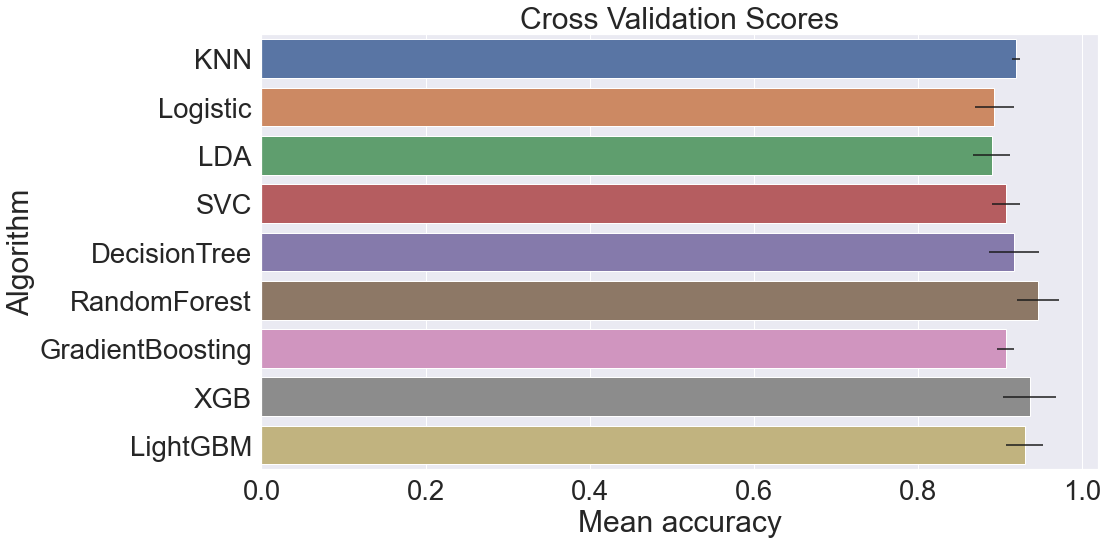

In [76]:
sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, **{'xerr':cv_std}, orient='h')
plt.title('Cross Validation Scores')
plt.xlabel('Mean accuracy')
fig = plt.gcf()
fig.set_size_inches(15,8)
plt.show()

In [87]:
temp = cv_res.sort_values(by='CrossValMeans', ascending=False)
temps = pd.concat([temp[['Algorithm']],temp[['CrossValMeans']], temp[['CrossValErrors']]], axis=1)
temps.columns = ['Algorithm', 'CVMeans', 'CVstd']
temps

,Algorithm,CVMeans,CVstd
5,RandomForest,0.945524,0.025547
7,XGB,0.935679,0.032169
8,LightGBM,0.929968,0.022466
0,KNN,0.919191,0.005001
4,DecisionTree,0.917252,0.030468
3,SVC,0.907485,0.016942
6,GradientBoosting,0.906775,0.010328
1,Logistic,0.892829,0.023556
2,LDA,0.889642,0.022323


RandomForest, XGBoost, LightGBM, Adaboost, KNN을 vote 모형에 사용할 기초모형들로 정했다.

### (1) KNN

In [244]:
knn = KNeighborsClassifier()

knn_param = {"n_neighbors":list(range(1,30))}

gs_knn = GridSearchCV(knn,param_grid = knn_param, cv=skf, scoring="recall", n_jobs= -1, verbose = 1)

gs_knn.fit(X_smote, y_smote)

gs_knn_best = gs_knn.best_estimator_

gs_knn_best.fit(X_smote, y_smote)

y_pred = gs_knn_best.predict(X_test)
confusion_matrix(y_test, y_pred)

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  3.9min finished


array([[2946,  589],
       [  76,  379]], dtype=int64)

### (2) RandomForest

In [245]:
rf = RandomForestClassifier(random_state=0)

rf_param = {  "max_features": [1, 3, 10],
              "min_samples_leaf": [1, 5, 10],
              "n_estimators" :[100,200,300],
              "criterion": ["gini", "entropy"]}

gs_rf = GridSearchCV(rf,param_grid = rf_param, cv=skf, scoring="recall", n_jobs= -1, verbose = 1)

gs_rf.fit(X_smote, y_smote)

gs_rf_best = gs_rf.best_estimator_
print(gs_rf_best)
gs_rf_best.fit(X_smote, y_smote)

y_pred = gs_rf_best.predict(X_test)
confusion_matrix(y_test, y_pred)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 25.6min finished


RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=300,
                       random_state=0)


array([[3253,  282],
       [ 118,  337]], dtype=int64)

### (3) LightGBM

In [246]:
lgbm = LGBMClassifier(random_state=0)
lgbm_param= {
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'num_leaves': [7, 15, 21, 35]
}

gs_lgbm = GridSearchCV(lgbm,param_grid = lgbm_param, cv=skf, scoring="precision", n_jobs= -1, verbose = 1)
gs_lgbm.fit(X_smote, y_smote)

gs_lgbm_best = gs_lgbm.best_estimator_
print(gs_lgbm_best)
gs_lgbm_best.fit(X_smote, y_smote)

y_pred = gs_lgbm_best.predict(X_test)
confusion_matrix(y_test, y_pred)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:  1.3min finished


LGBMClassifier(learning_rate=0.5, num_leaves=35, random_state=0)


array([[3247,  288],
       [ 127,  328]], dtype=int64)

### (4) XGBoost

In [247]:
xgb = XGBClassifier(random_state=0)
xgb_param = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

gs_xgb = GridSearchCV(xgb,param_grid = xgb_param, cv=skf, scoring="recall", n_jobs= -1, verbose = 1)
gs_xgb.fit(X_smote, y_smote)

gs_xgb_best = gs_xgb.best_estimator_
print(gs_xgb_best)
gs_xgb_best.fit(X_smote, y_smote)

y_pred = gs_xgb_best.predict(X_test)
confusion_matrix(y_test, y_pred)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  9.5min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


array([[3152,  383],
       [  84,  371]], dtype=int64)

### (5) Decision Tree --> accuracy 측면에서 AdaBoost가 0.03정도 높게 나왔으나, cv mean의 표준편차는 더 작으며, 적합 시간이라는 비용 측면에서 훨씬 빠르다.

In [248]:
tree = DecisionTreeClassifier(random_state=0)

tree_param = {'criterion':['gini','entropy'],
              'max_depth':range(1,10),
              'min_samples_split':range(1,10),
              'min_samples_leaf':range(1,5)}

gs_tree = GridSearchCV(tree,param_grid = tree_param, cv=skf, scoring="recall", n_jobs= -1, verbose = 1)

gs_tree.fit(X_smote, y_smote)

gs_tree_best = gs_tree.best_estimator_
print(gs_tree_best)
gs_tree_best.fit(X_smote, y_smote)

y_pred = gs_tree_best.predict(X_test)
confusion_matrix(y_test, y_pred)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3564 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4864 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 6332 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  4.9min finished


DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


array([[2634,  901],
       [  23,  432]], dtype=int64)

### (6) Ansemble

In [249]:
from sklearn.ensemble import VotingClassifier

vote_model = VotingClassifier(estimators=[('knn', gs_knn_best),('rf',gs_rf_best),('dt', gs_tree_best),('lgbm',gs_lgbm_best),('xgb',gs_xgb_best)], voting='hard', n_jobs=-1)
vote_model.fit(X_smote, y_smote)
vote_model.estimators_

[KNeighborsClassifier(n_neighbors=11),
 RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=300,
                        random_state=0),
 DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0),
 LGBMClassifier(learning_rate=0.05, num_leaves=35, random_state=0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.05, max_delta_step=0, max_depth=9,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)]

In [250]:
y_pred_train = vote_model.predict(X_smote)

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_smote, y_pred_train)))
print('Accuracy: {}'.format(round(accuracy_score(y_smote,y_pred_train),3)))
print('Precision: {}'.format(round(precision_score(y_smote, y_pred_train),3)))
print('Recall: {}'.format(round(recall_score(y_smote, y_pred_train),3)))
print('f1_score: {}'.format(round(f1_score(y_smote, y_pred_train),3)))
print(classification_report(y_smote, y_pred_train))

Confusion Matrix:
[[28439  3253]
 [  328 31364]]
Accuracy: 0.944
Precision: 0.906
Recall: 0.99
f1_score: 0.946
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     31692
           1       0.91      0.99      0.95     31692

    accuracy                           0.94     63384
   macro avg       0.95      0.94      0.94     63384
weighted avg       0.95      0.94      0.94     63384



In [251]:
y_pred = vote_model.predict(X_test)

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))
print('Accuracy: {}'.format(round(accuracy_score(y_test,y_pred),3)))
print('Precision: {}'.format(round(precision_score(y_test, y_pred),3)))
print('Recall: {}'.format(round(recall_score(y_test, y_pred),3)))
print('f1_score: {}'.format(round(f1_score(y_test, y_pred),3)))
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[3116  419]
 [  58  397]]
Accuracy: 0.88
Precision: 0.487
Recall: 0.873
f1_score: 0.625
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      3535
           1       0.49      0.87      0.62       455

    accuracy                           0.88      3990
   macro avg       0.73      0.88      0.78      3990
weighted avg       0.93      0.88      0.89      3990



In [252]:
vote_model.estimators_

[KNeighborsClassifier(n_neighbors=11),
 RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=300,
                        random_state=0),
 DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0),
 LGBMClassifier(learning_rate=0.05, num_leaves=35, random_state=0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.05, max_delta_step=0, max_depth=9,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)]

---

## Sol to overfit from SMOTE (12/09 돌려볼 것)

In [45]:
X_train_original = X.values
y_train_original = y.values

### (1) knn

In [46]:
from imblearn.pipeline import make_pipeline as imb_pipeline

skf = StratifiedKFold(n_splits=5, random_state=0)
accuracy_lst_knn = []
precision_lst_knn = []
recall_lst_knn = []
f1_lst_knn = []
auc_lst_knn = []

knn_sm2 = KNeighborsClassifier()

knn_param = {"n_neighbors":list(range(1,20))}

gs_knn_sm2 = GridSearchCV(knn_sm2,param_grid = knn_param, cv=skf, scoring="accuracy", n_jobs= -1, verbose = 1)

for train, test in skf.split(X_train_original, y_train_original):
    pipe = imb_pipeline(SMOTE(sampling_strategy='minority'), gs_knn_sm2)
    model = pipe.fit(X_train_original[train], y_train_original[train])
    best_est_knn = gs_knn_sm2.best_estimator_
    pred = best_est_knn.predict(X_train_original[test])
    accuracy_lst_knn.append(pipe.score(X_train_original[test], y_train_original[test]))
    precision_lst_knn.append(precision_score(y_train_original[test], pred))
    recall_lst_knn.append(recall_score(y_train_original[test], pred))
    f1_lst_knn.append(f1_score(y_train_original[test], pred))
    auc_lst_knn.append(roc_auc_score(y_train_original[test], pred))
        
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_knn)))
print("precision: {}".format(np.mean(precision_lst_knn)))
print("recall: {}".format(np.mean(recall_lst_knn)))
print("f1: {}".format(np.mean(f1_lst_knn)))
print('---' * 45)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.1min finished


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.1min finished


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.1min finished


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.0min finished


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.1min finished


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.8748499651081648
precision: 0.4651740005490054
recall: 0.5708430552498348
f1: 0.5125388553463102
---------------------------------------------------------------------------------------------------------------------------------------


### (2) Random Forest

In [47]:
from imblearn.pipeline import make_pipeline as imb_pipeline

skf = StratifiedKFold(n_splits=5, random_state=0)
accuracy_lst_rf = []
precision_lst_rf = []
recall_lst_rf = []
f1_lst_rf = []
auc_lst_rf = []

rf_sm2 = RandomForestClassifier(random_state=0)

rf_param = {  "max_features": [1, 3, 10],
              "min_samples_leaf": [1, 5, 10],
              "n_estimators" :[100,200,300],
              "criterion": ["gini", "entropy"]}

gs_rf_sm2 = GridSearchCV(rf_sm2,param_grid = rf_param, cv=skf, scoring="accuracy", n_jobs= -1, verbose = 1)

for train, test in skf.split(X_train_original, y_train_original):
    pipe = imb_pipeline(SMOTE(sampling_strategy='minority'), gs_rf_sm2)
    model = pipe.fit(X_train_original[train], y_train_original[train])
    best_est_rf = gs_rf_sm2.best_estimator_
    pred = best_est_rf.predict(X_train_original[test])
    accuracy_lst_rf.append(pipe.score(X_train_original[test], y_train_original[test]))
    precision_lst_rf.append(precision_score(y_train_original[test], pred))
    recall_lst_rf.append(recall_score(y_train_original[test], pred))
    f1_lst_rf.append(f1_score(y_train_original[test], pred))
    auc_lst_rf.append(roc_auc_score(y_train_original[test], pred))
        
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_rf)))
print("precision: {}".format(np.mean(precision_lst_rf)))
print("recall: {}".format(np.mean(recall_lst_rf)))
print("f1: {}".format(np.mean(f1_lst_rf)))
print('---' * 45)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.6min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.8min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.8min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.8min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.7min finished


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9037435491016375
precision: 0.5963675479553793
recall: 0.5117440751339057
f1: 0.5503236682739027
---------------------------------------------------------------------------------------------------------------------------------------


### (3) LightGBM

In [48]:
from imblearn.pipeline import make_pipeline as imb_pipeline

skf = StratifiedKFold(n_splits=5, random_state=0)
accuracy_lst_lgbm = []
precision_lst_lgbm = []
recall_lst_lgbm = []
f1_lst_lgbm = []
auc_lst_lgbm = []

lgbm_sm2 = LGBMClassifier(random_state=0)

lgbm_param= {
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'num_leaves': [7, 15, 21, 35]
}

gs_lgbm_sm2 = GridSearchCV(lgbm_sm2,param_grid = lgbm_param, cv=skf, scoring="accuracy", n_jobs= -1, verbose = 1)

for train, test in skf.split(X_train_original, y_train_original):
    pipe = imb_pipeline(SMOTE(sampling_strategy='minority'), gs_lgbm_sm2)
    model = pipe.fit(X_train_original[train], y_train_original[train])
    best_est_lgbm = gs_lgbm_sm2.best_estimator_
    pred = best_est_lgbm.predict(X_train_original[test])
    accuracy_lst_lgbm.append(pipe.score(X_train_original[test], y_train_original[test]))
    precision_lst_lgbm.append(precision_score(y_train_original[test], pred))
    recall_lst_lgbm.append(recall_score(y_train_original[test], pred))
    f1_lst_lgbm.append(f1_score(y_train_original[test], pred))
    auc_lst_lgbm.append(roc_auc_score(y_train_original[test], pred))
        
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_lgbm)))
print("precision: {}".format(np.mean(precision_lst_lgbm)))
print("recall: {}".format(np.mean(recall_lst_lgbm)))
print("f1: {}".format(np.mean(f1_lst_lgbm)))
print('---' * 45)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   35.3s finished


Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   34.7s finished


Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   34.8s finished


Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   34.5s finished


Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   34.7s finished


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.8983278219429318
precision: 0.5396026278344312
recall: 0.8074626164795656
f1: 0.6468370500341238
---------------------------------------------------------------------------------------------------------------------------------------


### (4) XGBoost

In [49]:
from imblearn.pipeline import make_pipeline as imb_pipeline

skf = StratifiedKFold(n_splits=5, random_state=0)
accuracy_lst_xgb = []
precision_lst_xgb = []
recall_lst_xgb = []
f1_lst_xgb = []
auc_lst_xgb = []

xgb_sm2 = XGBClassifier(random_state=0)

xgb_param = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

gs_xgb_sm2 = GridSearchCV(xgb_sm2,param_grid = xgb_param, cv=skf, scoring="accuracy", n_jobs= -1, verbose = 1)

for train, test in skf.split(X_train_original, y_train_original):
    pipe = imb_pipeline(SMOTE(sampling_strategy='minority'), gs_xgb_sm2)
    model = pipe.fit(X_train_original[train], y_train_original[train])
    best_est_xgb = gs_xgb_sm2.best_estimator_
    pred = best_est_xgb.predict(X_train_original[test])
    accuracy_lst_xgb.append(pipe.score(X_train_original[test], y_train_original[test]))
    precision_lst_xgb.append(precision_score(y_train_original[test], pred))
    recall_lst_xgb.append(recall_score(y_train_original[test], pred))
    f1_lst_xgb.append(f1_score(y_train_original[test], pred))
    auc_lst_xgb.append(roc_auc_score(y_train_original[test], pred))
        
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_xgb)))
print("precision: {}".format(np.mean(precision_lst_xgb)))
print("recall: {}".format(np.mean(recall_lst_xgb)))
print("f1: {}".format(np.mean(f1_lst_xgb)))
print('---' * 45)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.7min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.7min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.7min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.7min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.7min finished


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9055581349408124
precision: 0.5780095599654921
recall: 0.6904829407880255
f1: 0.6274156374185582
---------------------------------------------------------------------------------------------------------------------------------------


### (5) Decision Tree

In [50]:
from imblearn.pipeline import make_pipeline as imb_pipeline

skf = StratifiedKFold(n_splits=5, random_state=0)
accuracy_lst_dt = []
precision_lst_dt = []
recall_lst_dt = []
f1_lst_dt = []
auc_lst_dt = []

dt_sm2 = DecisionTreeClassifier()

tree_param = {'criterion':['gini','entropy'],
              'max_depth':range(1,10),
              'min_samples_split':range(1,10),
              'min_samples_leaf':range(1,5)}

gs_dt_sm2 = GridSearchCV(dt_sm2,param_grid = tree_param, cv=skf, scoring="accuracy", n_jobs= -1, verbose = 1)

for train, test in skf.split(X_train_original, y_train_original):
    pipe = imb_pipeline(SMOTE(sampling_strategy='minority'), gs_dt_sm2)
    model = pipe.fit(X_train_original[train], y_train_original[train])
    best_est_dt = gs_dt_sm2.best_estimator_
    pred = best_est_dt.predict(X_train_original[test])
    accuracy_lst_dt.append(pipe.score(X_train_original[test], y_train_original[test]))
    precision_lst_dt.append(precision_score(y_train_original[test], pred))
    recall_lst_dt.append(recall_score(y_train_original[test], pred))
    f1_lst_dt.append(f1_score(y_train_original[test], pred))
    auc_lst_dt.append(roc_auc_score(y_train_original[test], pred))
        
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_dt)))
print("precision: {}".format(np.mean(precision_lst_dt)))
print("recall: {}".format(np.mean(recall_lst_dt)))
print("f1: {}".format(np.mean(f1_lst_dt)))
print('---' * 45)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.0min finished


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.0min finished


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3229 out of 3240 | elapsed:  2.1min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.2min finished


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.0min finished


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  1.9min finished


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.8709975051655892
precision: 0.4673179752542378
recall: 0.8387115709149608
f1: 0.5999241478424555
---------------------------------------------------------------------------------------------------------------------------------------


In [54]:
print(best_est_knn)
print(best_est_rf)
print(best_est_dt)
print(best_est_lgbm)
print(best_est_xgb)

KNeighborsClassifier(n_neighbors=1)
RandomForestClassifier(max_features=1, n_estimators=300, random_state=0)
DecisionTreeClassifier(max_depth=9)
LGBMClassifier(n_estimators=50, num_leaves=35, random_state=0)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


- 모든 정확도

In [51]:
vote_smote = VotingClassifier(estimators=[('knn', best_est_knn),('rf',best_est_rf),('dt', best_est_dt),('lgbm',best_est_lgbm),('xgb',best_est_xgb)], voting='hard', n_jobs=-1)
vote_smote.fit(X_smote, y_smote)
vote_smote.estimators_
y_pred_train = vote_smote.predict(X_smote)

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_smote, y_pred_train)))
print('Accuracy: {}'.format(round(accuracy_score(y_smote,y_pred_train),3)))
print('Precision: {}'.format(round(precision_score(y_smote, y_pred_train),3)))
print('Recall: {}'.format(round(recall_score(y_smote, y_pred_train),3)))
print('f1_score: {}'.format(round(f1_score(y_smote, y_pred_train),3)))
print(classification_report(y_smote, y_pred_train))

Confusion Matrix:
[[29835  1857]
 [  372 31320]]
Accuracy: 0.965
Precision: 0.944
Recall: 0.988
f1_score: 0.966
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     31692
           1       0.94      0.99      0.97     31692

    accuracy                           0.96     63384
   macro avg       0.97      0.96      0.96     63384
weighted avg       0.97      0.96      0.96     63384



In [52]:
y_pred = vote_smote.predict(X_test)

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))
print('Accuracy: {}'.format(round(accuracy_score(y_test,y_pred),3)))
print('Precision: {}'.format(round(precision_score(y_test, y_pred),3)))
print('Recall: {}'.format(round(recall_score(y_test, y_pred),3)))
print('f1_score: {}'.format(round(f1_score(y_test, y_pred),3)))
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[3179  356]
 [  88  367]]
Accuracy: 0.889
Precision: 0.508
Recall: 0.807
f1_score: 0.623
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      3535
           1       0.51      0.81      0.62       455

    accuracy                           0.89      3990
   macro avg       0.74      0.85      0.78      3990
weighted avg       0.92      0.89      0.90      3990



---

- recall 기준

In [55]:
from imblearn.pipeline import make_pipeline as imb_pipeline

skf = StratifiedKFold(n_splits=5, random_state=0)
accuracy_lst_knn = []
precision_lst_knn = []
recall_lst_knn = []
f1_lst_knn = []
auc_lst_knn = []

knn_sm2 = KNeighborsClassifier()

knn_param = {"n_neighbors":list(range(1,20))}

gs_knn_sm2 = GridSearchCV(knn_sm2,param_grid = knn_param, cv=skf, scoring="recall", n_jobs= -1, verbose = 1)

for train, test in skf.split(X_train_original, y_train_original):
    pipe = imb_pipeline(SMOTE(sampling_strategy='minority'), gs_knn_sm2)
    model = pipe.fit(X_train_original[train], y_train_original[train])
    best_est_knn = gs_knn_sm2.best_estimator_
    pred = best_est_knn.predict(X_train_original[test])
    accuracy_lst_knn.append(pipe.score(X_train_original[test], y_train_original[test]))
    precision_lst_knn.append(precision_score(y_train_original[test], pred))
    recall_lst_knn.append(recall_score(y_train_original[test], pred))
    f1_lst_knn.append(f1_score(y_train_original[test], pred))
    auc_lst_knn.append(roc_auc_score(y_train_original[test], pred))
        
print("accuracy: {}".format(np.mean(accuracy_lst_knn)))
print("precision: {}".format(np.mean(precision_lst_knn)))
print("recall: {}".format(np.mean(recall_lst_knn)))
print("f1: {}".format(np.mean(f1_lst_knn)))

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.0min finished


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.0min finished


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.0min finished


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.0min finished


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.0min finished


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.8072201922371413
precision: 0.41945258367764005
recall: 0.8072201922371413
f1: 0.551937465571807
---------------------------------------------------------------------------------------------------------------------------------------


In [56]:
from imblearn.pipeline import make_pipeline as imb_pipeline

skf = StratifiedKFold(n_splits=5, random_state=0)
accuracy_lst_rf = []
precision_lst_rf = []
recall_lst_rf = []
f1_lst_rf = []
auc_lst_rf = []

rf_sm2 = RandomForestClassifier(random_state=0)

rf_param = {  "max_features": [1, 3, 10],
              "min_samples_leaf": [1, 5, 10],
              "n_estimators" :[100,200,300],
              "criterion": ["gini", "entropy"]}

gs_rf_sm2 = GridSearchCV(rf_sm2,param_grid = rf_param, cv=skf, scoring="recall", n_jobs= -1, verbose = 1)

for train, test in skf.split(X_train_original, y_train_original):
    pipe = imb_pipeline(SMOTE(sampling_strategy='minority'), gs_rf_sm2)
    model = pipe.fit(X_train_original[train], y_train_original[train])
    best_est_rf = gs_rf_sm2.best_estimator_
    pred = best_est_rf.predict(X_train_original[test])
    accuracy_lst_rf.append(pipe.score(X_train_original[test], y_train_original[test]))
    precision_lst_rf.append(precision_score(y_train_original[test], pred))
    recall_lst_rf.append(recall_score(y_train_original[test], pred))
    f1_lst_rf.append(f1_score(y_train_original[test], pred))
    auc_lst_rf.append(roc_auc_score(y_train_original[test], pred))
        
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_rf)))
print("precision: {}".format(np.mean(precision_lst_rf)))
print("recall: {}".format(np.mean(recall_lst_rf)))
print("f1: {}".format(np.mean(f1_lst_rf)))
print('---' * 45)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.5min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.6min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.6min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.6min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.5min finished


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.8108433487416539
precision: 0.5435647711643442
recall: 0.8108433487416539
f1: 0.6505405415628742
---------------------------------------------------------------------------------------------------------------------------------------


In [57]:
from imblearn.pipeline import make_pipeline as imb_pipeline

skf = StratifiedKFold(n_splits=5, random_state=0)
accuracy_lst_lgbm = []
precision_lst_lgbm = []
recall_lst_lgbm = []
f1_lst_lgbm = []
auc_lst_lgbm = []

lgbm_sm2 = LGBMClassifier(random_state=0)

lgbm_param= {
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'num_leaves': [7, 15, 21, 35]
}

gs_lgbm_sm2 = GridSearchCV(lgbm_sm2,param_grid = lgbm_param, cv=skf, scoring="recall", n_jobs= -1, verbose = 1)

for train, test in skf.split(X_train_original, y_train_original):
    pipe = imb_pipeline(SMOTE(sampling_strategy='minority'), gs_lgbm_sm2)
    model = pipe.fit(X_train_original[train], y_train_original[train])
    best_est_lgbm = gs_lgbm_sm2.best_estimator_
    pred = best_est_lgbm.predict(X_train_original[test])
    accuracy_lst_lgbm.append(pipe.score(X_train_original[test], y_train_original[test]))
    precision_lst_lgbm.append(precision_score(y_train_original[test], pred))
    recall_lst_lgbm.append(recall_score(y_train_original[test], pred))
    f1_lst_lgbm.append(f1_score(y_train_original[test], pred))
    auc_lst_lgbm.append(roc_auc_score(y_train_original[test], pred))
        
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_lgbm)))
print("precision: {}".format(np.mean(precision_lst_lgbm)))
print("recall: {}".format(np.mean(recall_lst_lgbm)))
print("f1: {}".format(np.mean(f1_lst_lgbm)))
print('---' * 45)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   34.4s finished


Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   34.3s finished


Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   34.1s finished


Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   34.0s finished


Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   34.4s finished


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.8963454398708637
precision: 0.48522457534453345
recall: 0.8963454398708637
f1: 0.6295105001273843
---------------------------------------------------------------------------------------------------------------------------------------


In [58]:
from imblearn.pipeline import make_pipeline as imb_pipeline

skf = StratifiedKFold(n_splits=5, random_state=0)
accuracy_lst_xgb = []
precision_lst_xgb = []
recall_lst_xgb = []
f1_lst_xgb = []
auc_lst_xgb = []

xgb_sm2 = XGBClassifier(random_state=0)

xgb_param = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

gs_xgb_sm2 = GridSearchCV(xgb_sm2,param_grid = xgb_param, cv=skf, scoring="recall", n_jobs= -1, verbose = 1)

for train, test in skf.split(X_train_original, y_train_original):
    pipe = imb_pipeline(SMOTE(sampling_strategy='minority'), gs_xgb_sm2)
    model = pipe.fit(X_train_original[train], y_train_original[train])
    best_est_xgb = gs_xgb_sm2.best_estimator_
    pred = best_est_xgb.predict(X_train_original[test])
    accuracy_lst_xgb.append(pipe.score(X_train_original[test], y_train_original[test]))
    precision_lst_xgb.append(precision_score(y_train_original[test], pred))
    recall_lst_xgb.append(recall_score(y_train_original[test], pred))
    f1_lst_xgb.append(f1_score(y_train_original[test], pred))
    auc_lst_xgb.append(roc_auc_score(y_train_original[test], pred))
        
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_xgb)))
print("precision: {}".format(np.mean(precision_lst_xgb)))
print("recall: {}".format(np.mean(recall_lst_xgb)))
print("f1: {}".format(np.mean(f1_lst_xgb)))
print('---' * 45)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.6min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.7min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.7min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.7min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.7min finished


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.8549305158118716
precision: 0.506173992506249
recall: 0.8549305158118716
f1: 0.6357588560968725
---------------------------------------------------------------------------------------------------------------------------------------


In [59]:
from imblearn.pipeline import make_pipeline as imb_pipeline

skf = StratifiedKFold(n_splits=5, random_state=0)
accuracy_lst_dt = []
precision_lst_dt = []
recall_lst_dt = []
f1_lst_dt = []
auc_lst_dt = []

dt_sm2 = DecisionTreeClassifier()

tree_param = {'criterion':['gini','entropy'],
              'max_depth':range(1,10),
              'min_samples_split':range(1,10),
              'min_samples_leaf':range(1,5)}

gs_dt_sm2 = GridSearchCV(dt_sm2,param_grid = tree_param, cv=skf, scoring="recall", n_jobs= -1, verbose = 1)

for train, test in skf.split(X_train_original, y_train_original):
    pipe = imb_pipeline(SMOTE(sampling_strategy='minority'), gs_dt_sm2)
    model = pipe.fit(X_train_original[train], y_train_original[train])
    best_est_dt = gs_dt_sm2.best_estimator_
    pred = best_est_dt.predict(X_train_original[test])
    accuracy_lst_dt.append(pipe.score(X_train_original[test], y_train_original[test]))
    precision_lst_dt.append(precision_score(y_train_original[test], pred))
    recall_lst_dt.append(recall_score(y_train_original[test], pred))
    f1_lst_dt.append(f1_score(y_train_original[test], pred))
    auc_lst_dt.append(roc_auc_score(y_train_original[test], pred))
        
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_dt)))
print("precision: {}".format(np.mean(precision_lst_dt)))
print("recall: {}".format(np.mean(recall_lst_dt)))
print("f1: {}".format(np.mean(f1_lst_dt)))
print('---' * 45)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.0min finished


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.0min finished


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.0min finished


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.0min finished


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  1.9min finished


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9590722723604082
precision: 0.3210277279612681
recall: 0.9590722723604082
f1: 0.48101134650047017
---------------------------------------------------------------------------------------------------------------------------------------


In [89]:
best_est_knn.n_neighbors

5

In [60]:
print(best_est_knn)
print(best_est_rf)
print(best_est_dt)
print(best_est_lgbm)
print(best_est_xgb)

KNeighborsClassifier()
RandomForestClassifier(criterion='entropy', max_features=10,
                       min_samples_leaf=10, n_estimators=200, random_state=0)
DecisionTreeClassifier(criterion='entropy', max_depth=3)
LGBMClassifier(learning_rate=0.05, n_estimators=50, num_leaves=35,
               random_state=0)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [61]:
vote_smote = VotingClassifier(estimators=[('knn', best_est_knn),('rf',best_est_rf),('dt', best_est_dt),('lgbm',best_est_lgbm),
                                          ('xgb',best_est_xgb)], voting='hard', n_jobs=-1)
vote_smote.fit(X_smote, y_smote)



vote_smote.estimators_
y_pred_train = vote_smote.predict(X_smote)

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_smote, y_pred_train)))
print('Accuracy: {}'.format(round(accuracy_score(y_smote,y_pred_train),3)))
print('Precision: {}'.format(round(precision_score(y_smote, y_pred_train),3)))
print('Recall: {}'.format(round(recall_score(y_smote, y_pred_train),3)))
print('f1_score: {}'.format(round(f1_score(y_smote, y_pred_train),3)))
print(classification_report(y_smote, y_pred_train))

Confusion Matrix:
[[28045  3647]
 [  630 31062]]
Accuracy: 0.933
Precision: 0.895
Recall: 0.98
f1_score: 0.936
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     31692
           1       0.89      0.98      0.94     31692

    accuracy                           0.93     63384
   macro avg       0.94      0.93      0.93     63384
weighted avg       0.94      0.93      0.93     63384



In [62]:
y_pred = vote_smote.predict(X_test)

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))
print('Accuracy: {}'.format(round(accuracy_score(y_test,y_pred),3)))
print('Precision: {}'.format(round(precision_score(y_test, y_pred),3)))
print('Recall: {}'.format(round(recall_score(y_test, y_pred),3)))
print('f1_score: {}'.format(round(f1_score(y_test, y_pred),3)))
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[3088  447]
 [  43  412]]
Accuracy: 0.877
Precision: 0.48
Recall: 0.905
f1_score: 0.627
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3535
           1       0.48      0.91      0.63       455

    accuracy                           0.88      3990
   macro avg       0.73      0.89      0.78      3990
weighted avg       0.93      0.88      0.89      3990



---

In [224]:
xgb = XGBClassifier(random_state=0)
xgb_param = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

gs2xgb = GridSearchCV(xgb,param_grid = xgb_param, cv=skf, scoring="accuracy", n_jobs= -1, verbose = 1)
gs2xgb.fit(X, y)

gs2xgb_best = gs2xgb.best_estimator_

# Best scroe
gs2xgb.best_score_

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  4.2min finished


0.915608097547308

In [225]:
gs2xgb_best.fit(X_smote, y_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [226]:
y_p = gs2xgb_best.predict(X_smote)
print(confusion_matrix(y_smote, y_p))
print(classification_report(y_smote, y_p))
y_p = gs2xgb_best.predict(X_test)
print(confusion_matrix(y_test, y_p))
print(classification_report(y_test, y_p))

[[27570  4122]
 [ 1178 30514]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     31692
           1       0.88      0.96      0.92     31692

    accuracy                           0.92     63384
   macro avg       0.92      0.92      0.92     63384
weighted avg       0.92      0.92      0.92     63384

[[3053  482]
 [  54  401]]
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      3535
           1       0.45      0.88      0.60       455

    accuracy                           0.87      3990
   macro avg       0.72      0.87      0.76      3990
weighted avg       0.92      0.87      0.88      3990



In [409]:
# # final model(재현용)
# gs_knn_best2 = KNeighborsClassifier(n_neighbors=3)

# gs_rf_best2 = RandomForestClassifier(criterion='entropy', max_features=10, min_samples_leaf=10, n_estimators=200, random_state=0)

# gs_ada_best2 =  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0), learning_rate=0.2, n_estimators=100, random_state=0)

# gs_gb_best2 = GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features=0.3,min_samples_leaf=150, random_state=0)

# gs_xgb_best2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#                importance_type='gain', interaction_constraints='',
#                learning_rate=0.01, max_delta_step=0, max_depth=3,
#                min_child_weight=1, missing=nan, monotone_constraints='()',
#                n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
#                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
#                tree_method='exact', validate_parameters=1, verbosity=None)

# vote_model2 = VotingClassifier(estimators=[('knn', gs_knn_best2),('rf',gs_rf_best2),('ada', gs_ada_best2),('gb',gs_gb_best2),('xgb',gs_xgb_best2)], voting='hard', n_jobs=-1)
# vote_model2.fit(X_smote, y_smote)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('rf',
                              RandomForestClassifier(max_features=10,
                                                     min_samples_leaf=10,
                                                     n_estimators=20,
                                                     random_state=0)),
                             ('ada',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                                 learning_rate=0.3,
                                                 n_estimators=100,
                                                 random_state=0)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=...
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',

In [410]:
# y_pred_recall = vote_model2.predict(X_test)

# print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_pred_recall)))
# print('Accuracy: {}'.format(round(accuracy_score(y_test,y_pred_recall),3)))
# print('Precision: {}'.format(round(precision_score(y_test, y_pred_recall),3)))
# print('Recall: {}'.format(round(recall_score(y_test, y_pred_recall),3)))
# print('f1_score: {}'.format(round(f1_score(y_test, y_pred_recall),3)))
# print(classification_report(y_test, y_pred_recall))

Confusion Matrix:
[[7833  974]
 [ 188  961]]
Accuracy: 0.883
Precision: 0.497
Recall: 0.836
f1_score: 0.623
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      8807
           1       0.50      0.84      0.62      1149

    accuracy                           0.88      9956
   macro avg       0.74      0.86      0.78      9956
weighted avg       0.92      0.88      0.90      9956



- 최종 모형1은 Recall이 0.836으로 마케팅의 효과로 실제 정기 예금 상품에 가입한 사람 중 약 83.6%의 사람을 가입했다고 예측했다. 즉, 가입하지 않은 사람 중 가입했다고 예측한 비율은 약 11%이다.

---

# Accuracy score 기준(돌려볼 것)

In [205]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
random_state=0

skf = StratifiedKFold(n_splits=10, random_state=0)

classifiers=[]
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(SVC(kernel='rbf',random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(LGBMClassifier(random_state=random_state))


cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_smote, y_smote, scoring='accuracy', cv=skf, n_jobs=6))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans': cv_means, 
                      'CrossValErrors': cv_std,
                      'Algorithm': ['KNN','Logistic','LDA','SVC','DecisionTree','AdaBoost','RandomForest','GradientBoosting','XGB','LightGBM']})

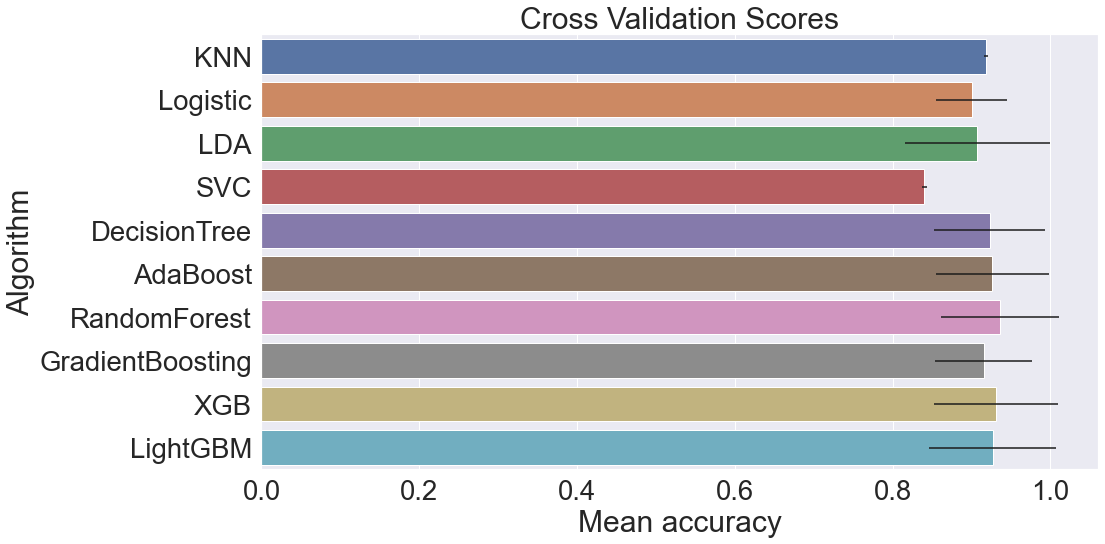

In [206]:
sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, **{'xerr':cv_std}, orient='h')
plt.title('Cross Validation Scores')
plt.xlabel('Mean accuracy')
fig = plt.gcf()
fig.set_size_inches(15,8)
plt.show()

In [207]:
cv_res.sort_values(by='CrossValMeans', ascending=False)

,CrossValMeans,CrossValErrors,Algorithm
6,0.936186,0.074334,RandomForest
8,0.931468,0.078703,XGB
9,0.926814,0.080727,LightGBM
5,0.926656,0.072161,AdaBoost
4,0.922964,0.070274,DecisionTree
0,0.918434,0.002711,KNN
7,0.915391,0.061877,GradientBoosting
2,0.907583,0.091585,LDA
1,0.900229,0.045200,Logistic
3,0.840212,0.003322,SVC


- RandomForest, XGBoost, LightGBM, AdaBoost, KNN(cv error 가 가장 작음)을 선택한다.

### (1) Random Forest

In [208]:
rf = RandomForestClassifier(random_state=0)

rf_param = {  "max_features": [1, 3, 10],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "n_estimators" :[100,200,300],
              "criterion": ["gini"]}

acc_rf = GridSearchCV(rf,param_grid = rf_param, cv=skf, scoring="accuracy", n_jobs= -1, verbose = 1)

acc_rf.fit(X_smote, y_smote)

acc_rf_best = acc_rf.best_estimator_

# Best scroe
acc_rf.best_score_

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 30.4min finished


0.9369901177755737

In [226]:
m = acc_rf.best_estimator_
m.fit(X_smote, y_smote)
p = m.predict(X_smote)
print(classification_report(y_smote, p))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31692
           1       0.99      0.99      0.99     31692

    accuracy                           0.99     63384
   macro avg       0.99      0.99      0.99     63384
weighted avg       0.99      0.99      0.99     63384



### (2) XGBoost

In [209]:
xgb = XGBClassifier(random_state=0)
xgb_param = {
    'max_depth': [3, 5, 7], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

acc_xgb = GridSearchCV(xgb,param_grid = xgb_param, cv=skf, scoring="accuracy", n_jobs= -1, verbose = 1)
acc_xgb.fit(X_smote, y_smote)

acc_xgb_best = acc_xgb.best_estimator_

# Best scroe
acc_xgb.best_score_

Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  4.6min finished


0.9304427041603489

### (3) LightGBM

In [210]:
lgbm = LGBMClassifier(random_state=0)
lgbm_param= {
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'num_leaves': [7, 15, 21, 35]
}

acc_lgbm = GridSearchCV(lgbm,param_grid = lgbm_param, cv=skf, scoring="accuracy", n_jobs= -1, verbose = 1)
acc_lgbm.fit(X_smote, y_smote)

acc_lgbm_best = acc_lgbm.best_estimator_

# Best scroe
acc_lgbm.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:  1.2min finished


0.9320365032545576

### (4) AdaBoost

In [211]:
tree = DecisionTreeClassifier(random_state=0)
ada = AdaBoostClassifier(tree, random_state=0)

ada_param = {"n_estimators" :[5,10,50,100],
                  "learning_rate":  [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1]}

acc_ada = GridSearchCV(ada,param_grid = ada_param, cv=skf, scoring="accuracy", n_jobs= -1, verbose = 1)

acc_ada.fit(X_smote, y_smote)

acc_ada_best = acc_ada.best_estimator_

# Best scroe
acc_ada.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed: 21.1min finished


0.9400343314421322

### (5) KNN

In [212]:
knn = KNeighborsClassifier()

knn_param = {"n_neighbors":list(range(1,30))}

acc_knn = GridSearchCV(knn,param_grid = knn_param, cv=skf, scoring="accuracy", n_jobs= -1, verbose = 1)

acc_knn.fit(X_smote, y_smote)

acc_knn_best = acc_knn.best_estimator_

# Best scroe
acc_knn.best_score_

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  1.3min finished


0.9370191172559179

### (-) Ansemble

In [218]:
vote_acc = VotingClassifier(estimators=[('rf', acc_rf_best),('xgb',acc_xgb_best),('lgbm', acc_lgbm_best),('ada',acc_ada_best),('knn',acc_knn_best)], voting='hard', n_jobs=-1)
vote_acc.fit(X_smote, y_smote)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_features=3,
                                                     min_samples_split=5,
                                                     random_state=0)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=7, min_child_weig...
                                            reg_alpha=0, reg_lambda=1,
                                            scale_pos_w

In [227]:
# train set 평가
y_pred_acc_train = vote_acc.predict(X_smote)
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_smote, y_pred_acc_train)))
print('Accuracy: {}'.format(round(accuracy_score(y_smote,y_pred_acc_train),3)))
print('Precision: {}'.format(round(precision_score(y_smote, y_pred_acc_train),3)))
print('Recall: {}'.format(round(recall_score(y_smote, y_pred_acc_train),3)))
print('f1_score: {}'.format(round(f1_score(y_smote, y_pred_acc_train),3)))
print(classification_report(y_smote, y_pred_acc_train))

Confusion Matrix:
[[31487   205]
 [  295 31397]]
Accuracy: 0.992
Precision: 0.994
Recall: 0.991
f1_score: 0.992
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31692
           1       0.99      0.99      0.99     31692

    accuracy                           0.99     63384
   macro avg       0.99      0.99      0.99     63384
weighted avg       0.99      0.99      0.99     63384



In [228]:
# test set 평가
y_pred_acc = vote_acc.predict(X_test)

print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_pred_acc)))
print('Accuracy: {}'.format(round(accuracy_score(y_test,y_pred_acc),3)))
print('Precision: {}'.format(round(precision_score(y_test, y_pred_acc),3)))
print('Recall: {}'.format(round(recall_score(y_test, y_pred_acc),3)))
print('f1_score: {}'.format(round(f1_score(y_test, y_pred_acc),3)))
print(classification_report(y_test, y_pred_acc))

Confusion Matrix:
[[3311  224]
 [ 170  285]]
Accuracy: 0.901
Precision: 0.56
Recall: 0.626
f1_score: 0.591
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3535
           1       0.56      0.63      0.59       455

    accuracy                           0.90      3990
   macro avg       0.76      0.78      0.77      3990
weighted avg       0.91      0.90      0.90      3990



---

---